In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
ORSkey=os.environ['ORSkey']

In [2]:
import numpy as np
import pandas as pd
import folium
import ast
import openrouteservice as ors
import random

In [3]:
locations = pd.read_csv("../foodstuffs-data/FoodstuffsLocations.csv")
locations.head()

,Type,Location,Supermarket,Long,Lat
0,New World,Albany,New World Albany,174.710513,-36.728144
1,New World,Birkenhead,New World Birkenhead,174.711486,-36.811428
2,New World,Botany,New World Botany,174.911491,-36.933883
3,New World,Browns Bay,New World Browns Bay,174.747287,-36.715961
4,New World,Devonport,New World Devonport,174.796193,-36.829510


In [4]:
selected_saturday = pd.read_csv("../linear-program/output/SelectedRoutesSaturday.csv")
selected_saturday.head()

,RouteNum,Route,TruckType,RouteCost
0,r1171,"['Warehouse', 'New World Victoria Park', 'New ...",OwnedTruck,199.725417
1,r15,"['Warehouse', ""Pak 'n Save Manukau"", 'Four Squ...",OwnedTruck,228.684167
2,r247,"['Warehouse', 'Four Square Fair Price Henderso...",OwnedTruck,211.790000
3,r265,"['Warehouse', ""Pak 'n Save Henderson"", 'Four S...",OwnedTruck,215.960833
4,r322,"['Warehouse', 'New World Botany', ""Pak 'n Save...",OwnedTruck,270.636250


In [5]:
selected_weekday = pd.read_csv("../linear-program/output/SelectedRoutesWeekday.csv")
selected_weekday.head()

,RouteNum,Route,TruckType,RouteCost
0,r190,"['Warehouse', ""Pak 'n Save Botany"", 'New World...",OwnedTruck,205.303750
1,r199,"['Warehouse', 'Four Square Cockle Bay', 'New W...",OwnedTruck,267.785000
2,r216,"['Warehouse', 'New World Ormiston', ""Pak 'n Sa...",OwnedTruck,197.378333
3,r223,"['Warehouse', 'New World Birkenhead', 'New Wor...",OwnedTruck,206.072083
4,r233,"['Warehouse', 'New World Long Bay', 'Four Squa...",OwnedTruck,265.615833


In [6]:
def initialise_map(locations):
    """ Initialise map and plot store locations.

        Parameters
        ----------
        locations : dataframe
            Location of stores.
        
        Returns
        -------
        m : object
            Map object with plotted store locations.
    """
    coords = locations[['Long', 'Lat']] # Mapping packages work with Long, Lat arrays
    coords = coords.to_numpy().tolist() # Make the arrays into a list of lists.
    # Folium, however, requires Lat, Long arrays - so a reversal is needed.
    # coords[0] is the warehouse
    m = folium.Map(location = list(reversed(coords[2])), zoom_start=10.25)
    for i in range(len(locations)):
        if locations.Type[i] == "Four Square":
            icon_url = "store_green.png"
        elif locations.Type[i] == "New World":
            icon_url = "store_red.png"
        elif locations.Type[i] == "Pak 'n Save":
            icon_url = "store_orange.png"
        elif locations.Type[i] == "Warehouse":
            icon_url = "warehouse.png"
        icon = folium.features.CustomIcon(icon_url, icon_size=(16, 16))
        folium.Marker(
            list(reversed(coords[i])),
            popup = locations.Supermarket[i],
            icon = icon # folium.Icon(color = iconCol)
        ).add_to(m)
    return m

In [7]:
def find_driving_route(coords):
    """ Find driving route between stores in a route.

        Parameters
        ----------
        coords : list
            List of coordinates of store locations within route.
        
        Returns
        -------
        object
            Driving route.
    """
    client = ors.Client(key=ORSkey)
    
    return client.directions(
        coordinates = coords,
        profile = 'driving-hgv', # can be driving-car, driving-hgv, etc.
        format='geojson',
        validate = False
    )

In [8]:
def plot_routes(locations, routes, m):
    """ Plot driving routes of selected routes between stores.

        Parameters
        ----------
        locations : dataframe
            Locations of nodes.
        routes : dataframe
            Selected routes.
        m : object
            Map object.
        
        Returns
        -------
        m : object
            Map object with plotted routes.
    """
    route_list = [ast.literal_eval(route) for route in routes.Route.values.tolist()]
    for route in route_list:
        coord_list = []
        for node in route:
            coord = locations[locations.Supermarket==node][['Long', 'Lat']]
            coord = coord.to_numpy().tolist()
            coord_list.append(coord[0])
        
        driving_route = find_driving_route(coord_list)
        coordinates = driving_route['features'][0]['geometry']['coordinates']
        folium.PolyLine(
            locations = [list(reversed(coord)) for coord in coordinates],
            color = '#' + ''.join([random.choice('ABCDEF0123456789') for i in range(6)])
        ).add_to(m)
    return m


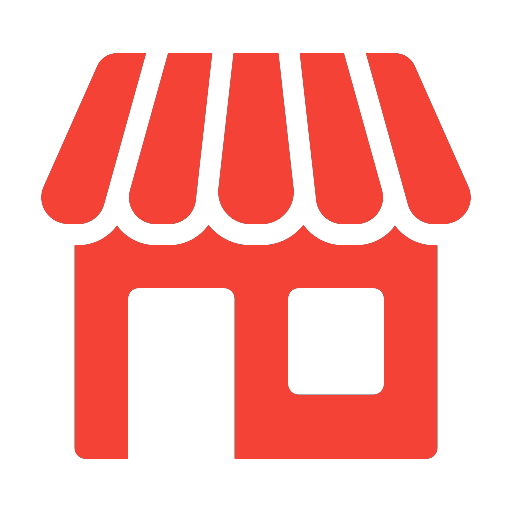
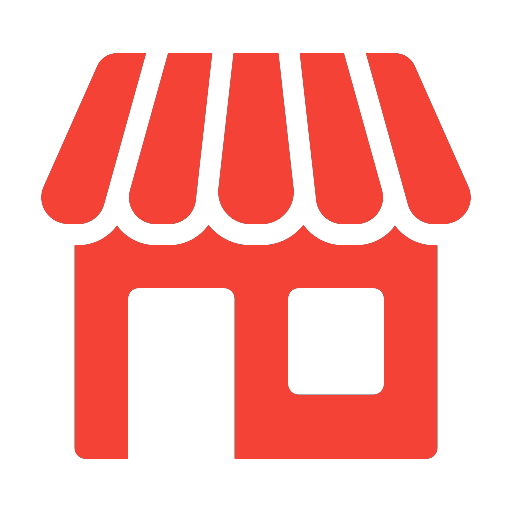
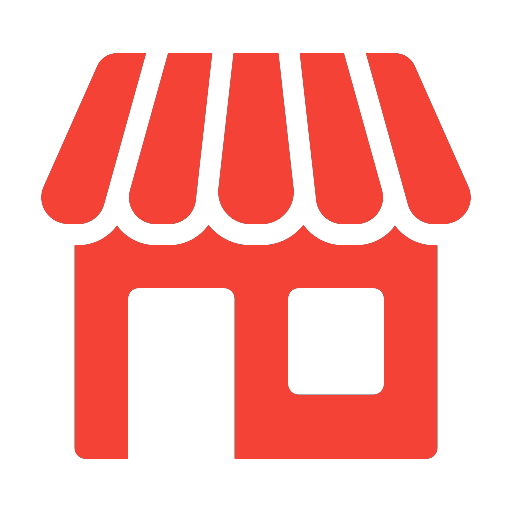
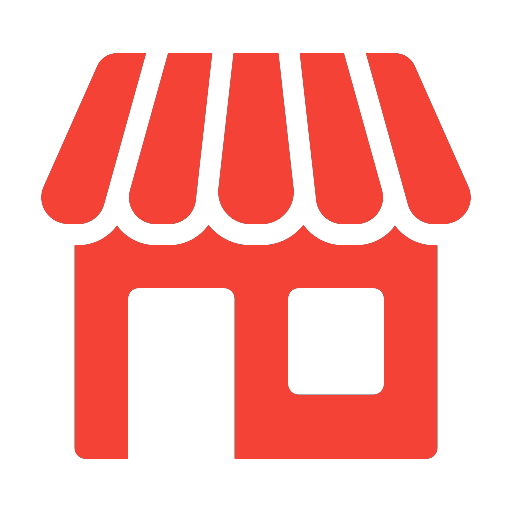
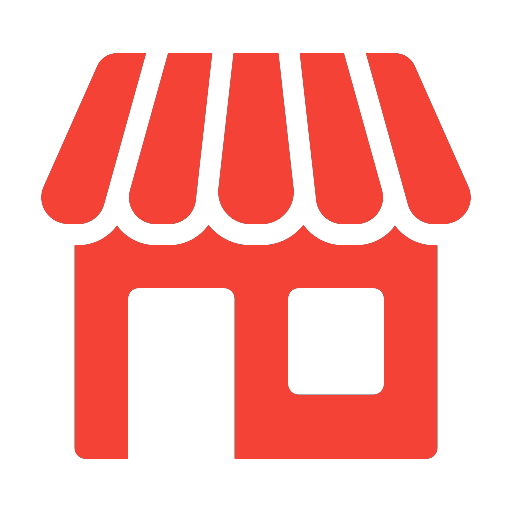
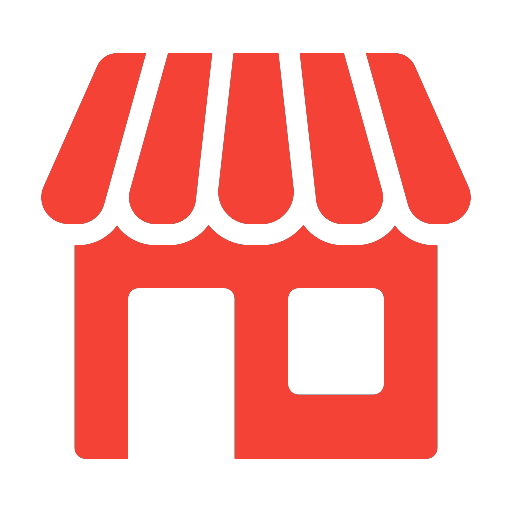
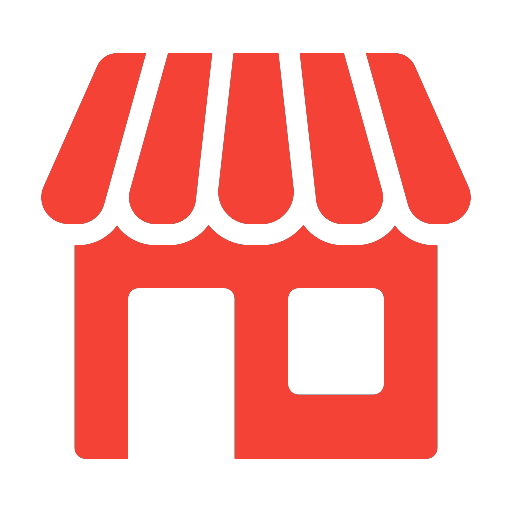
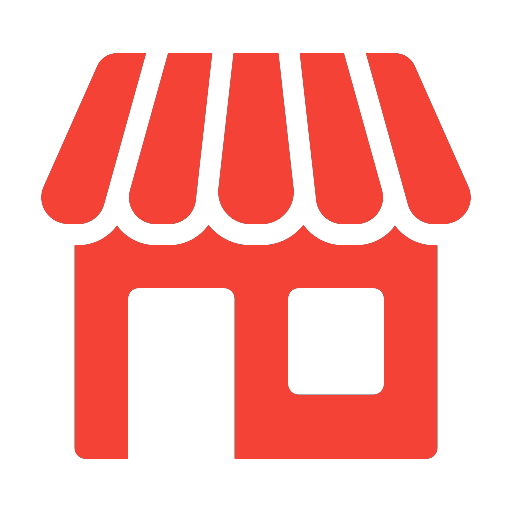
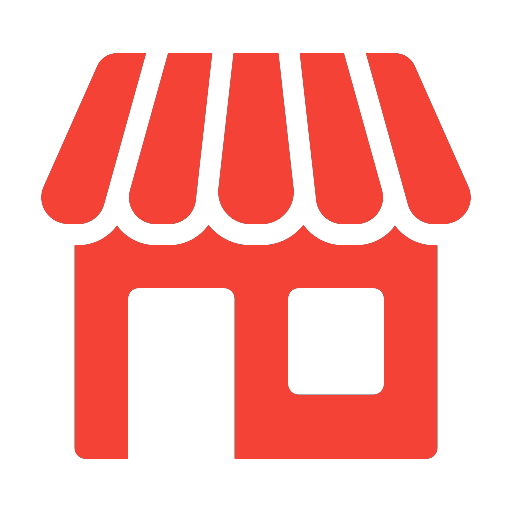
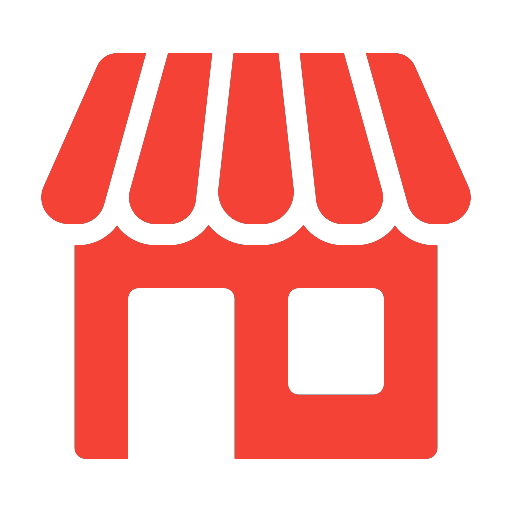
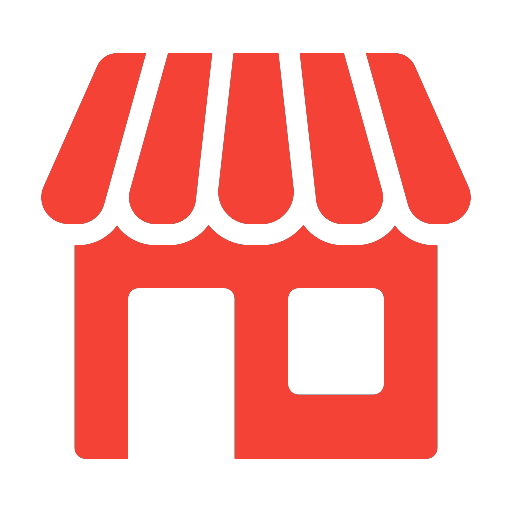
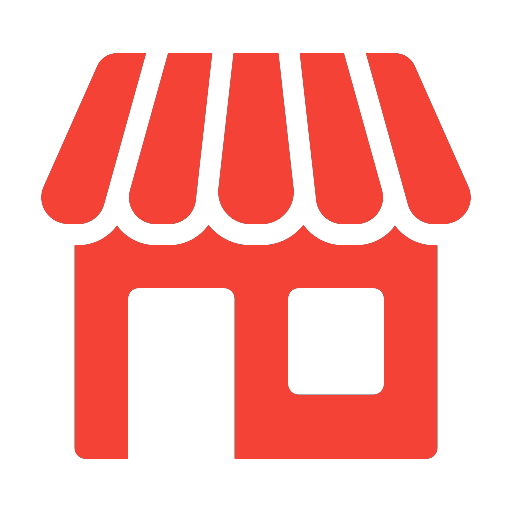
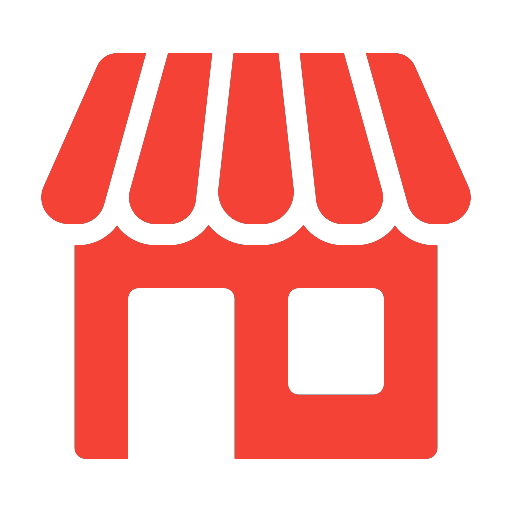
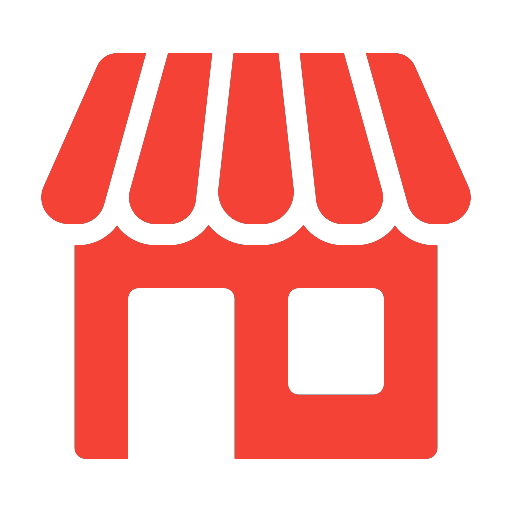
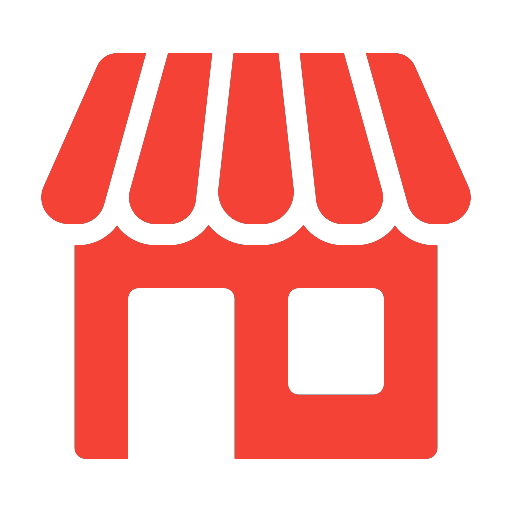
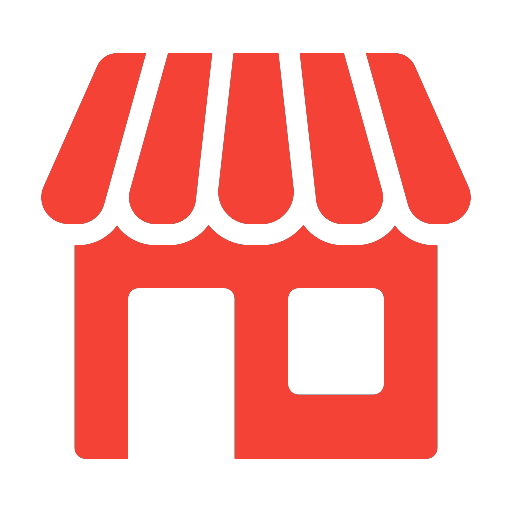
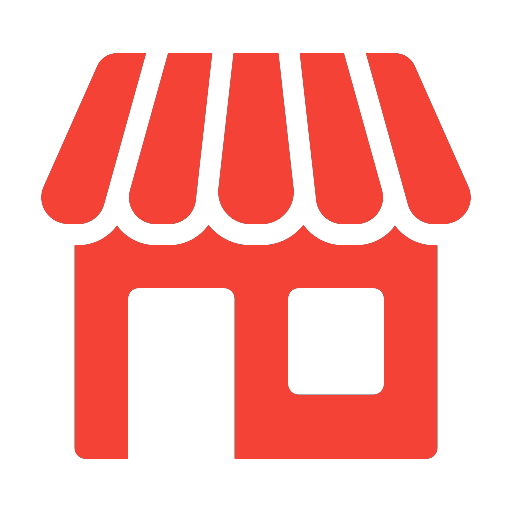
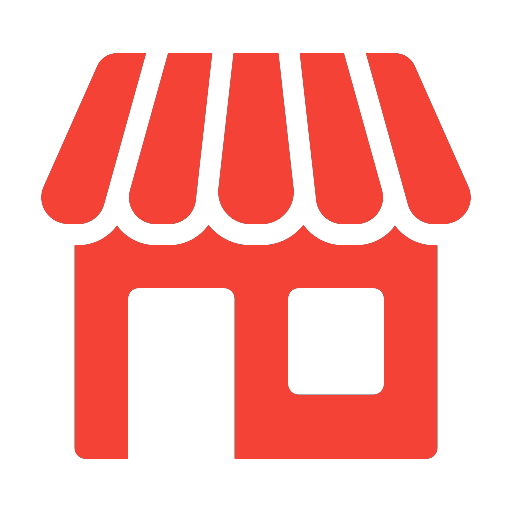
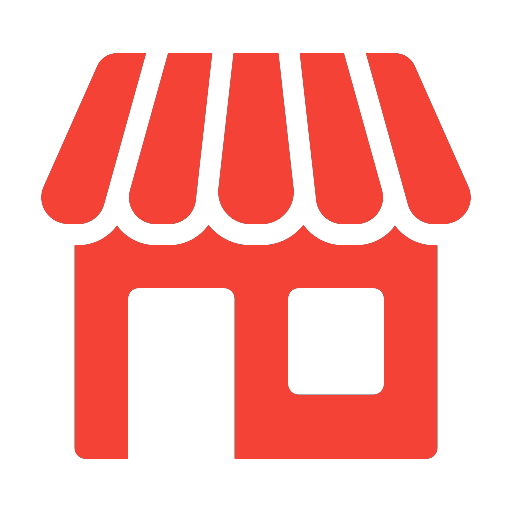
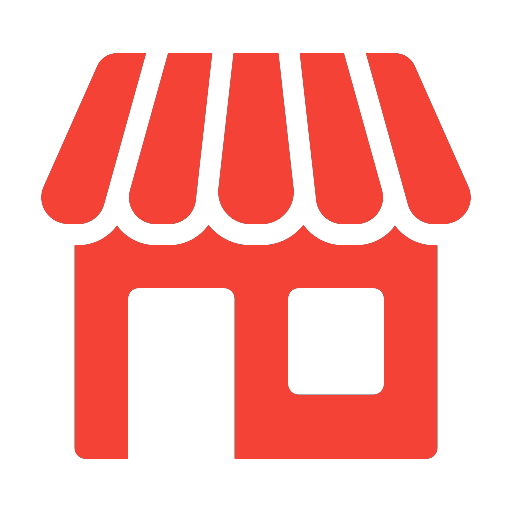
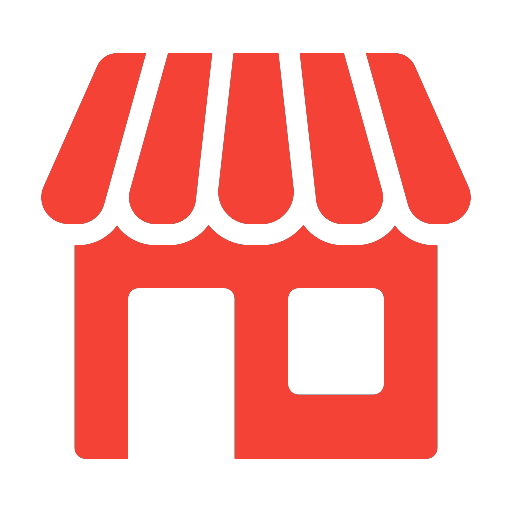
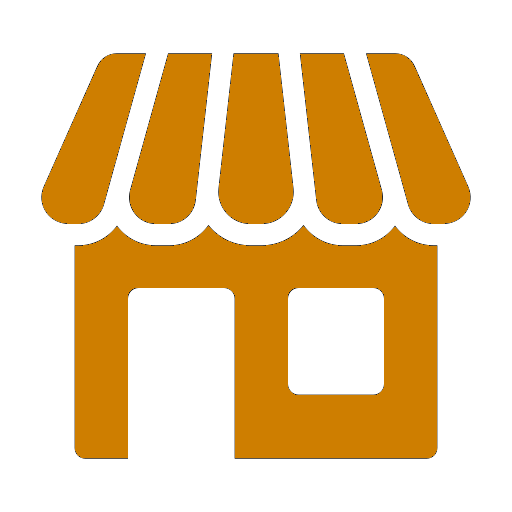
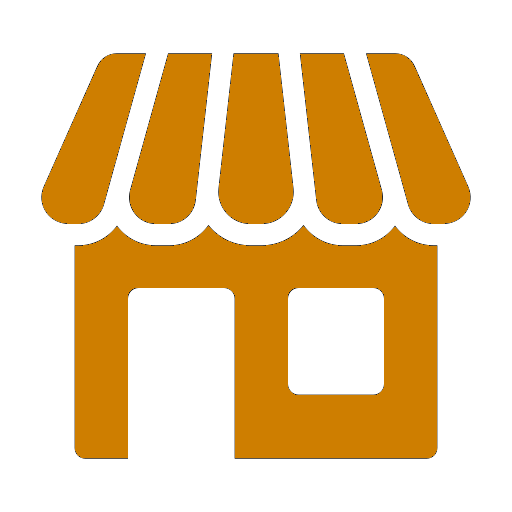
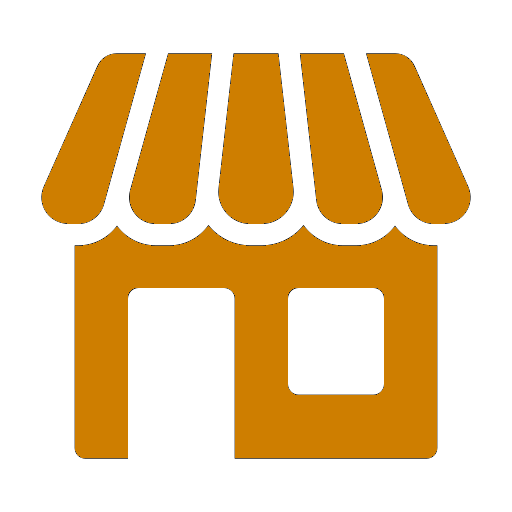
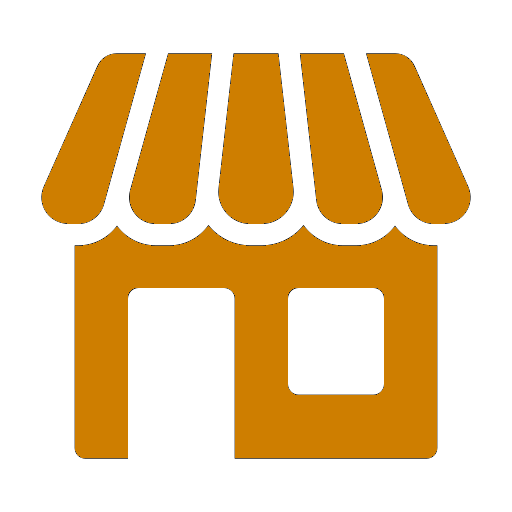
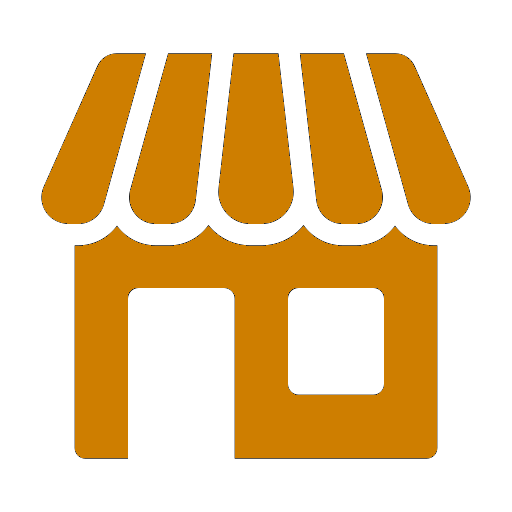
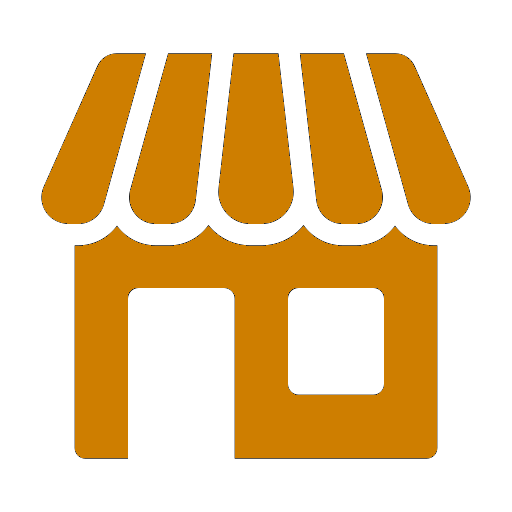
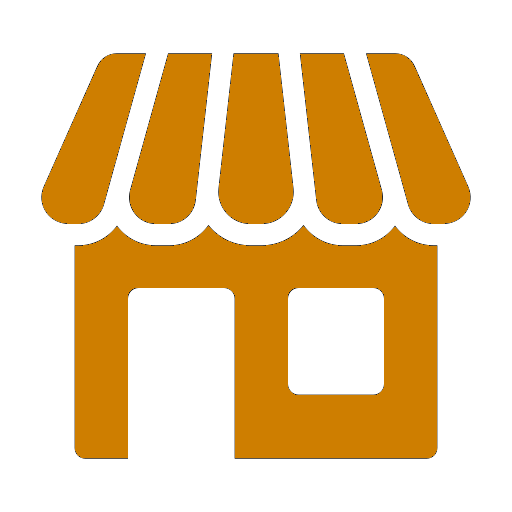
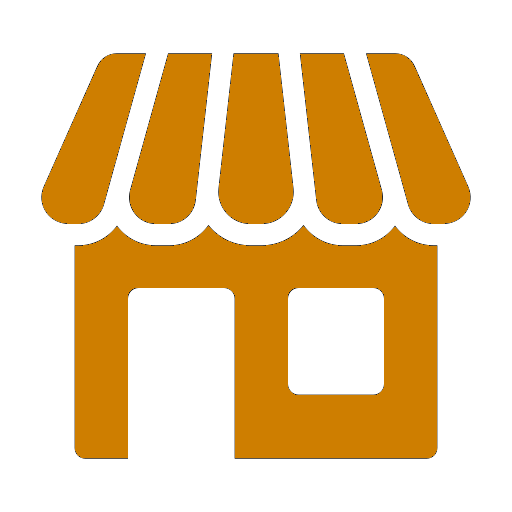
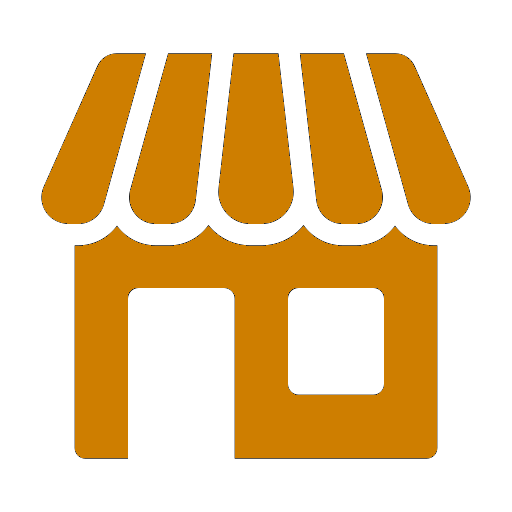
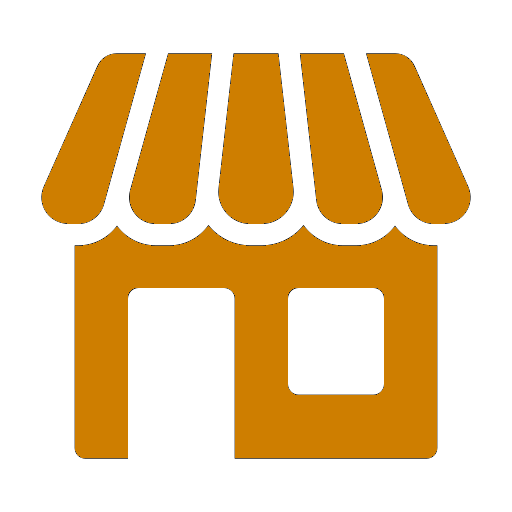
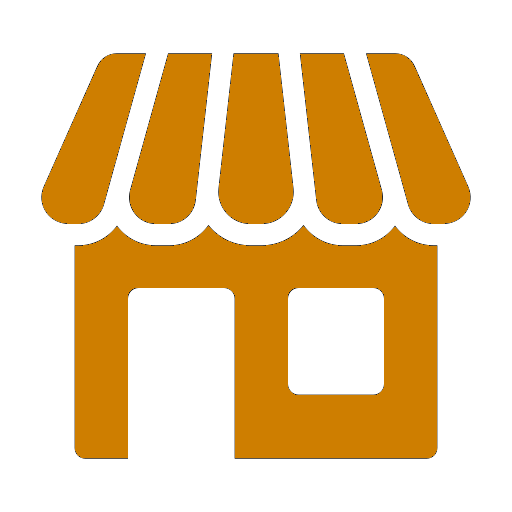
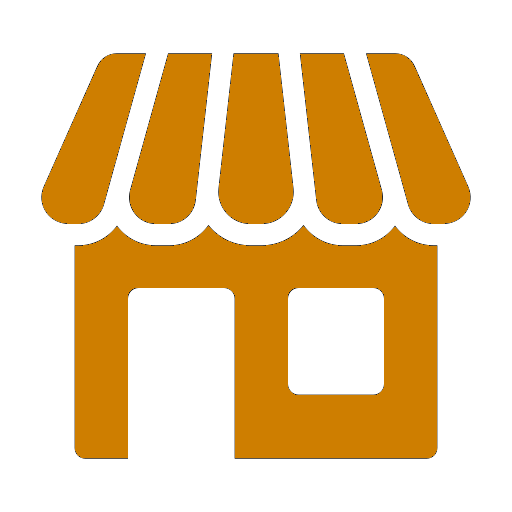
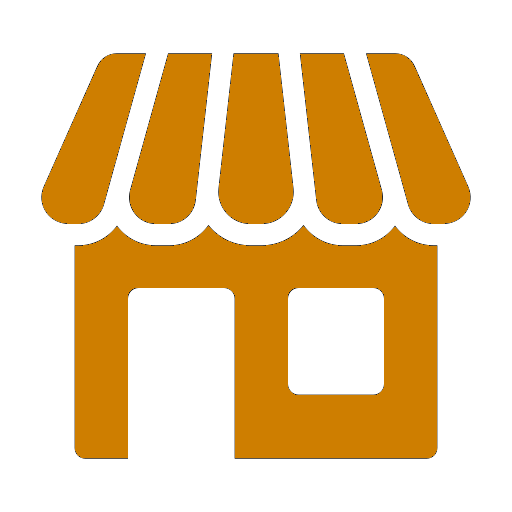
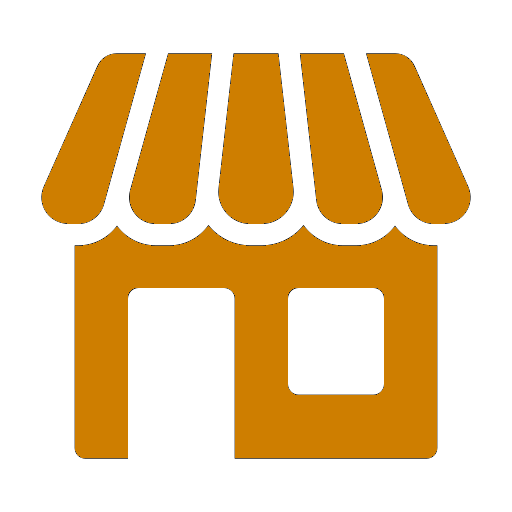
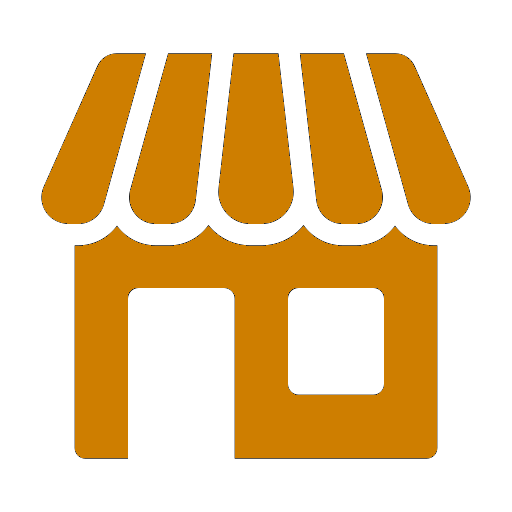
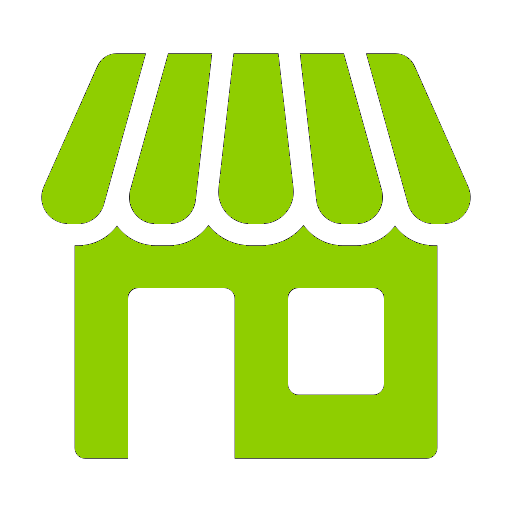
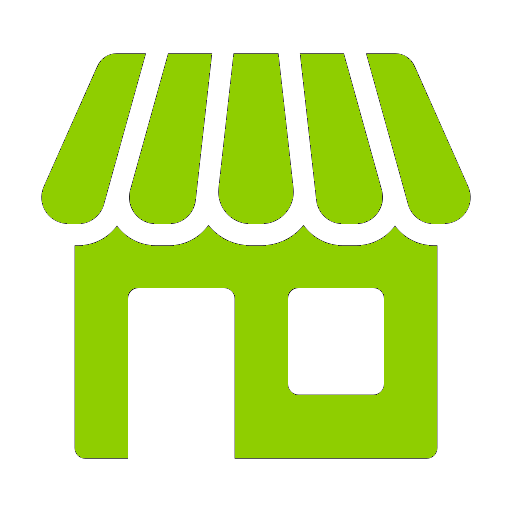
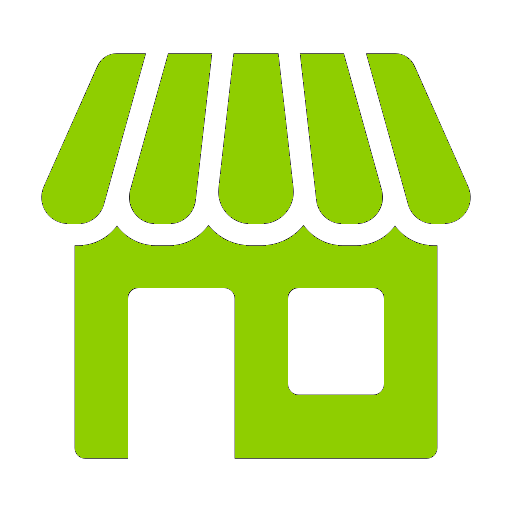
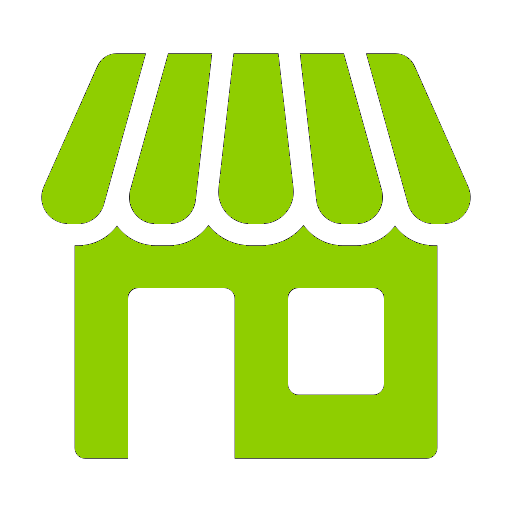
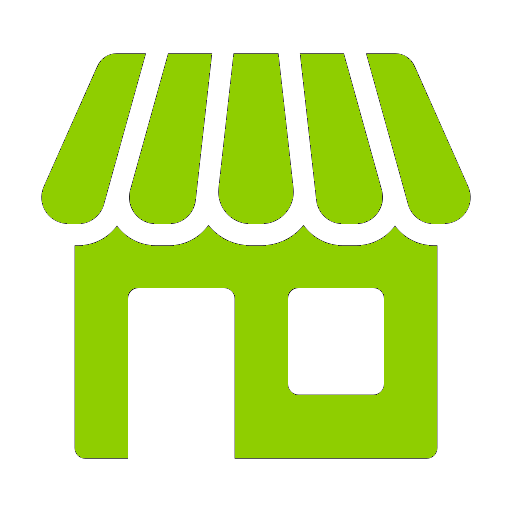
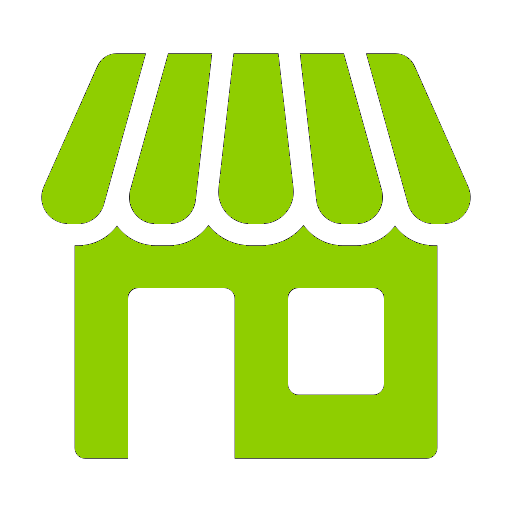
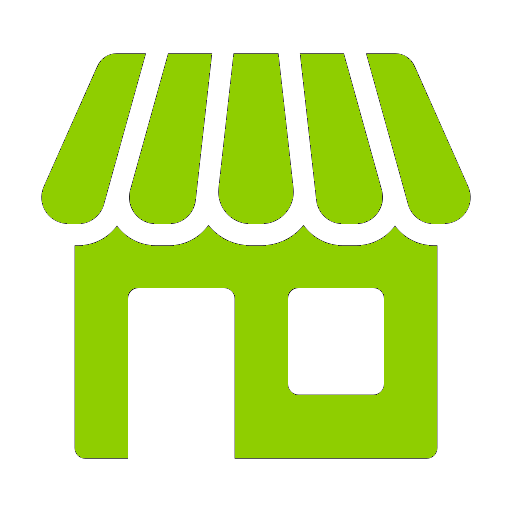
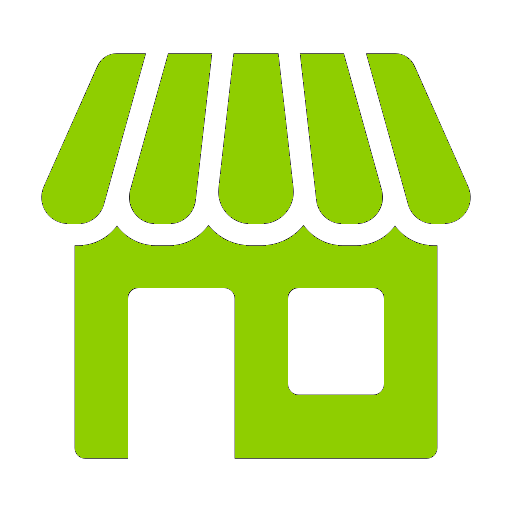
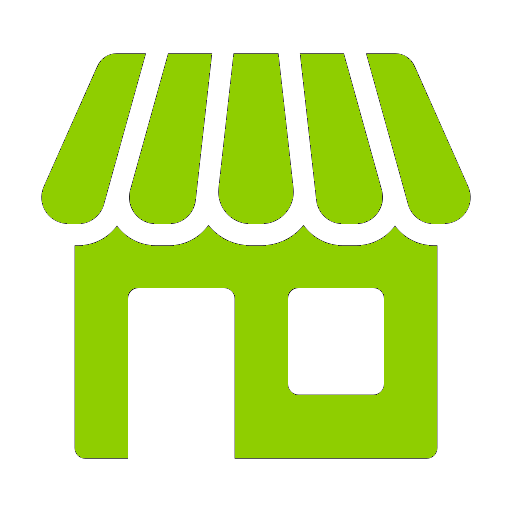
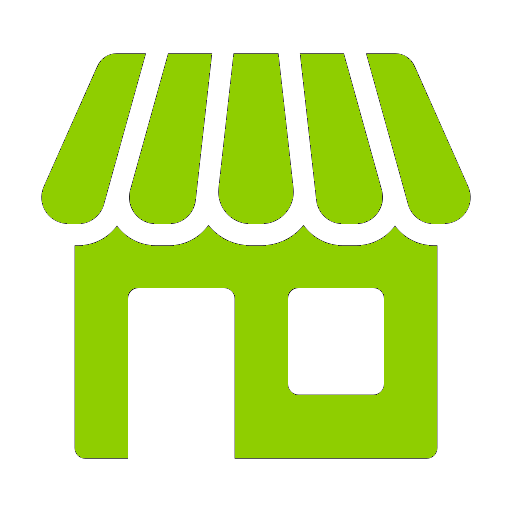
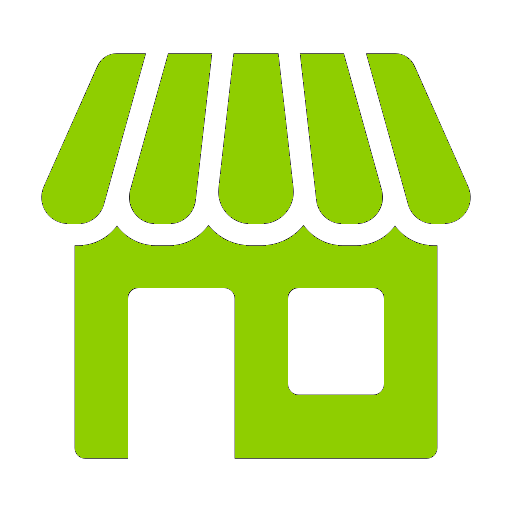
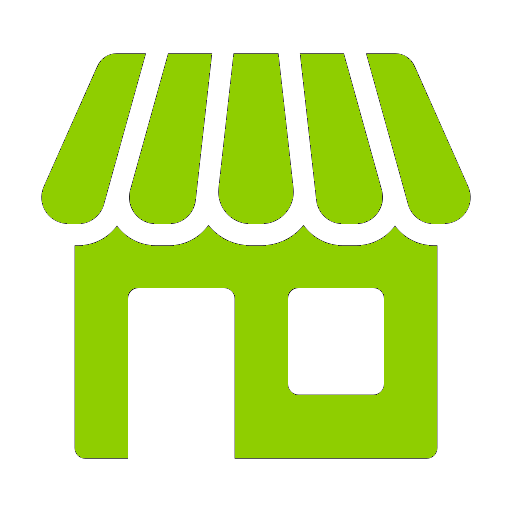
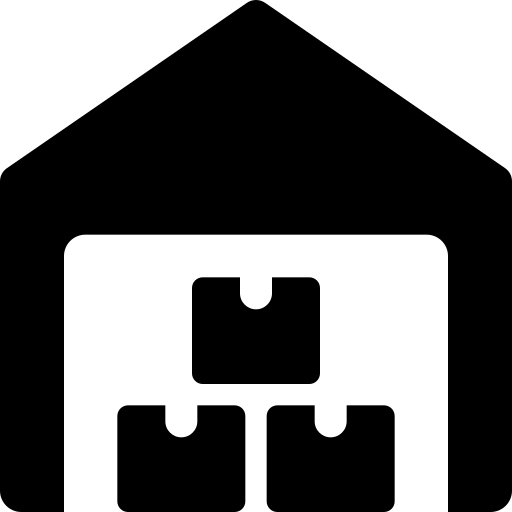

In [9]:
initialise_map(locations)


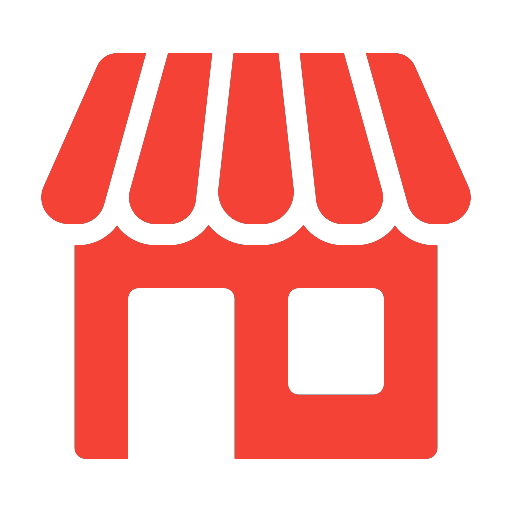
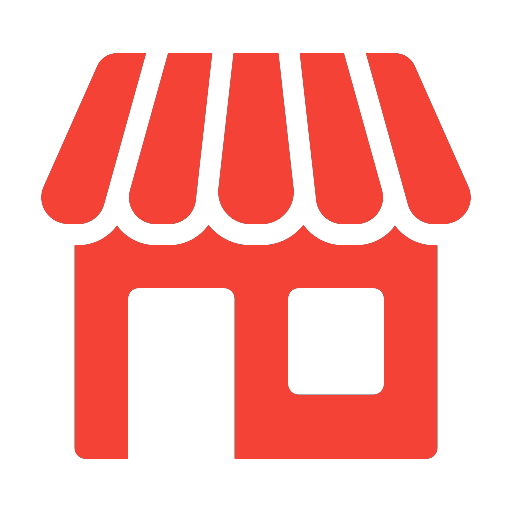
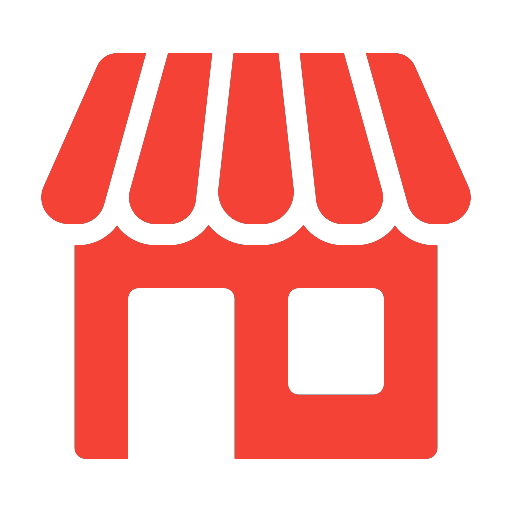
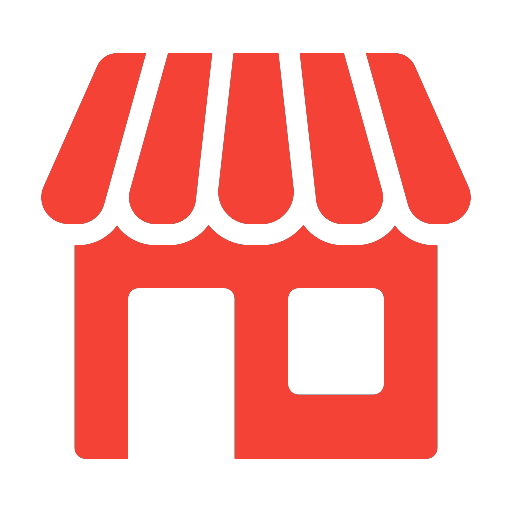
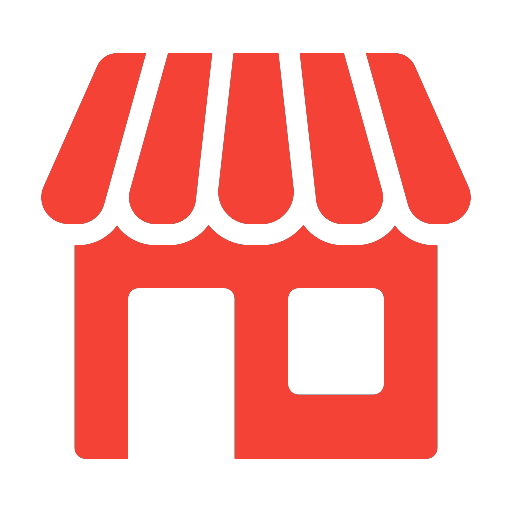
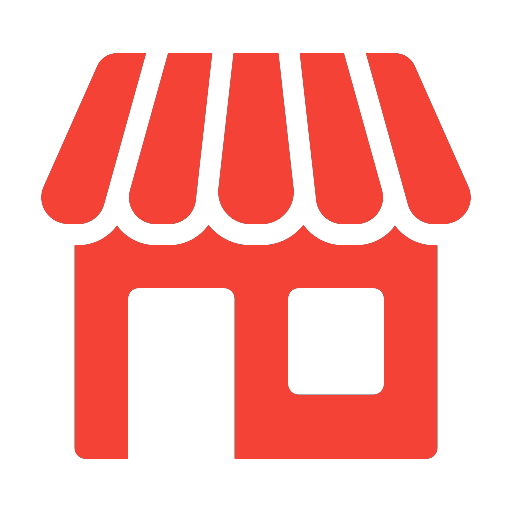
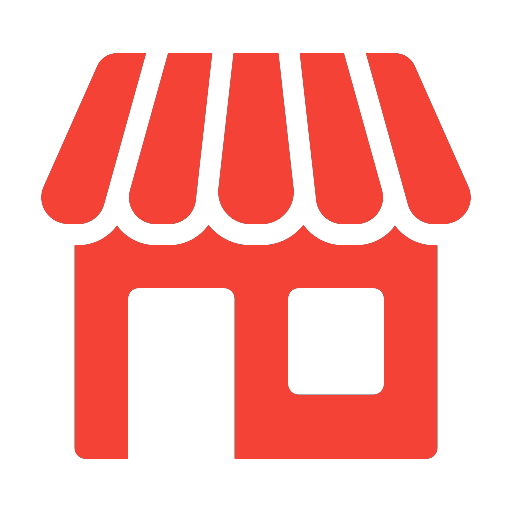
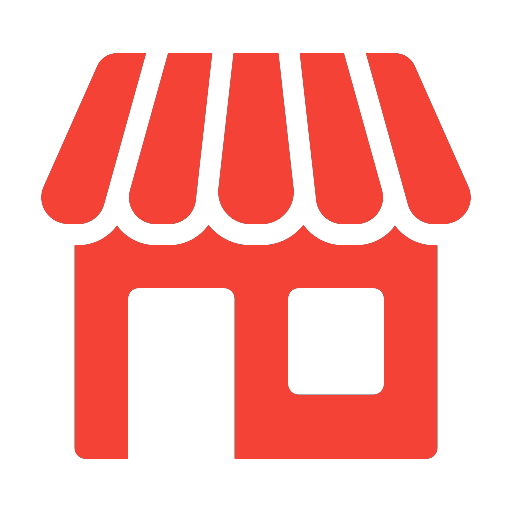
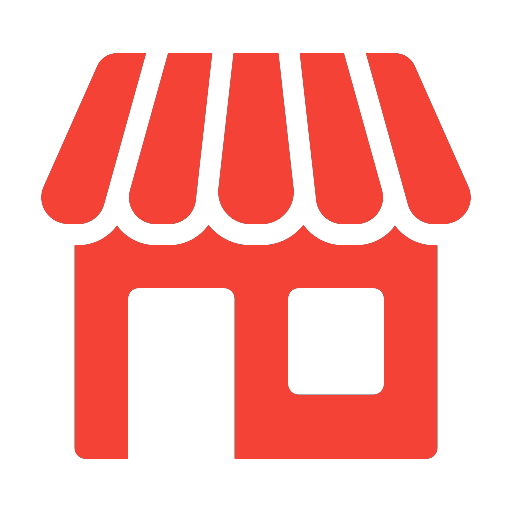
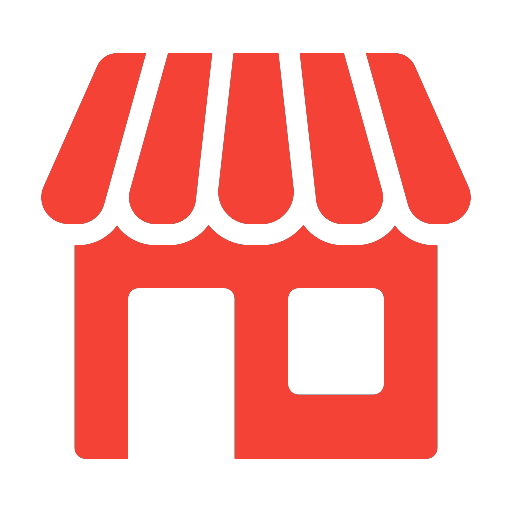
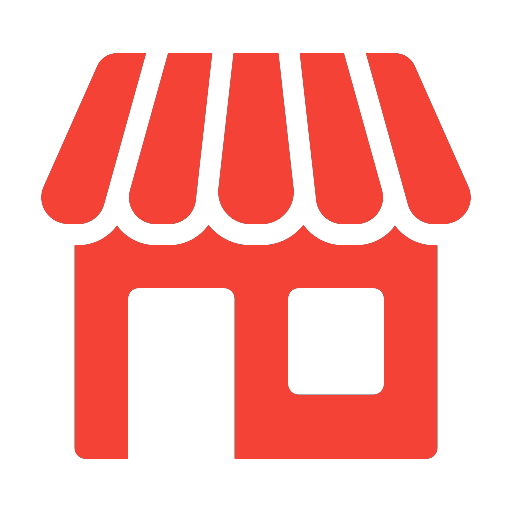
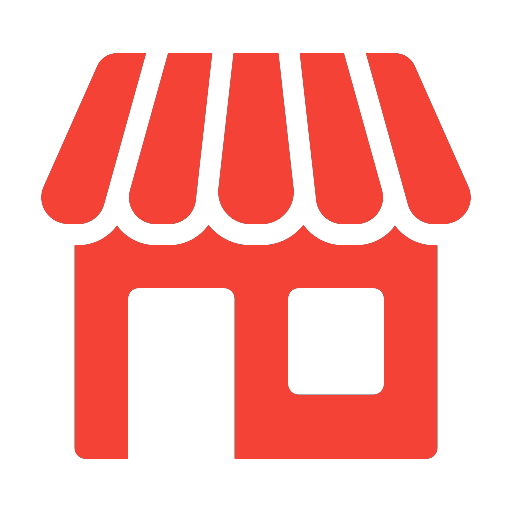
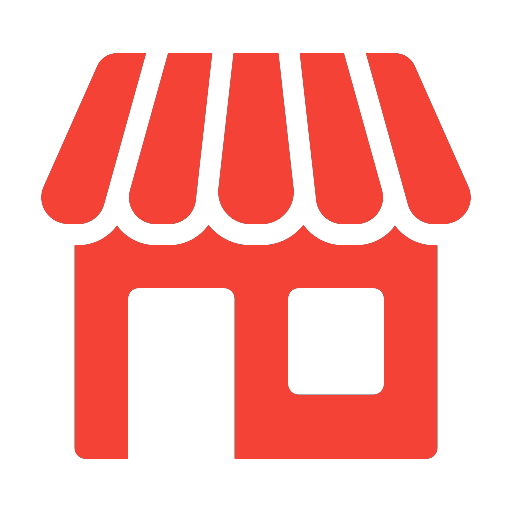
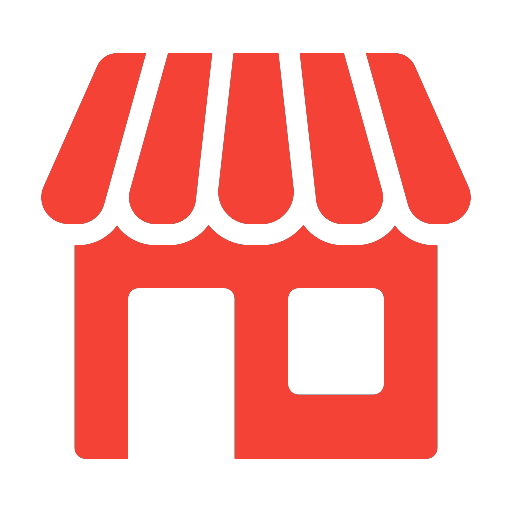
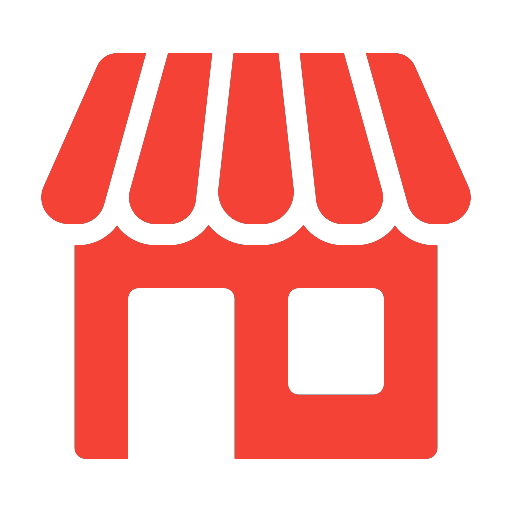
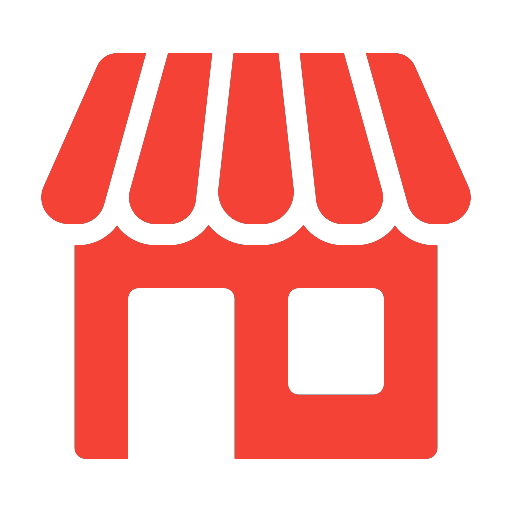
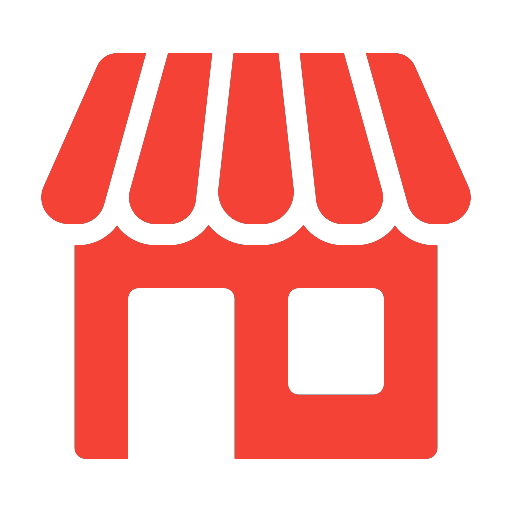
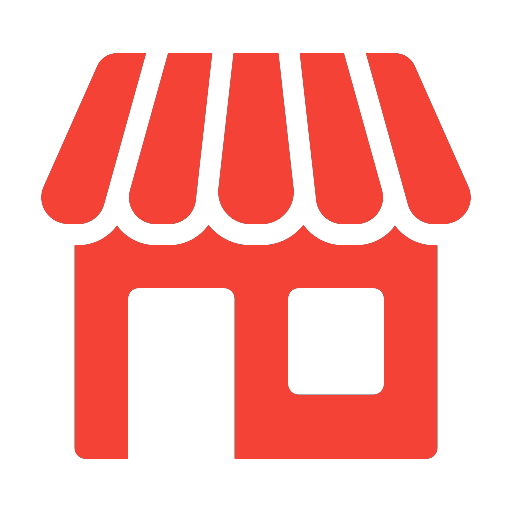
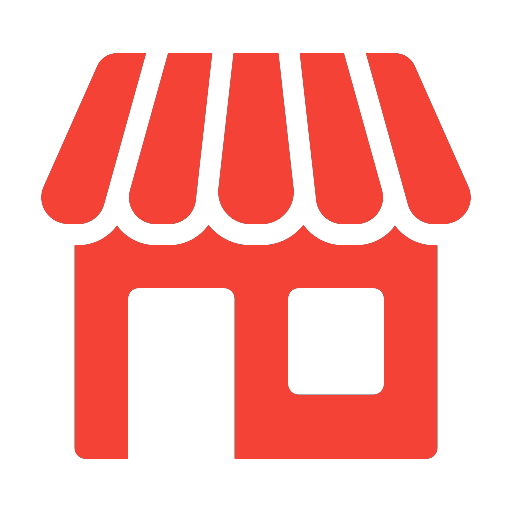
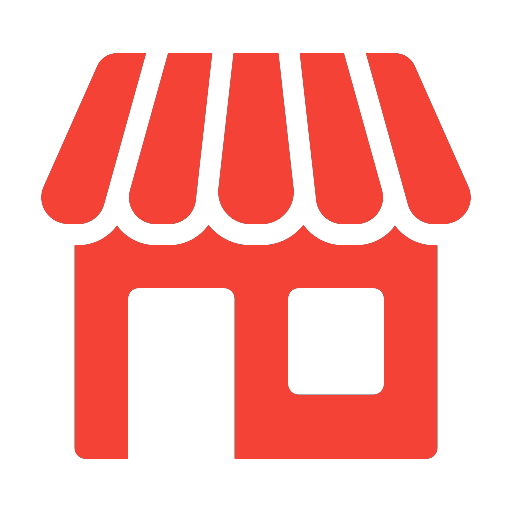
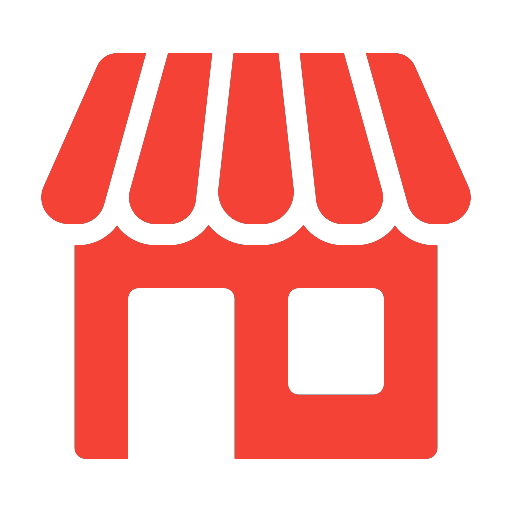
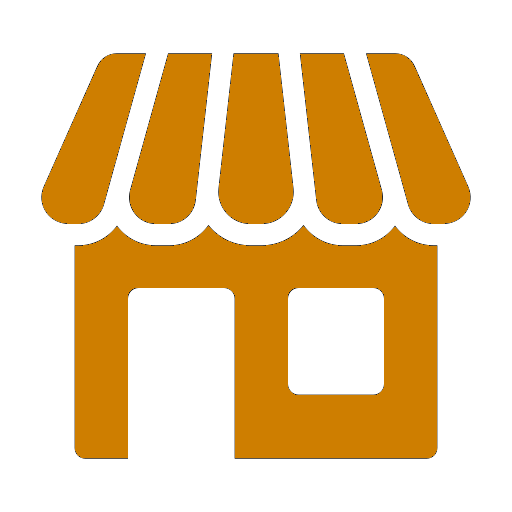
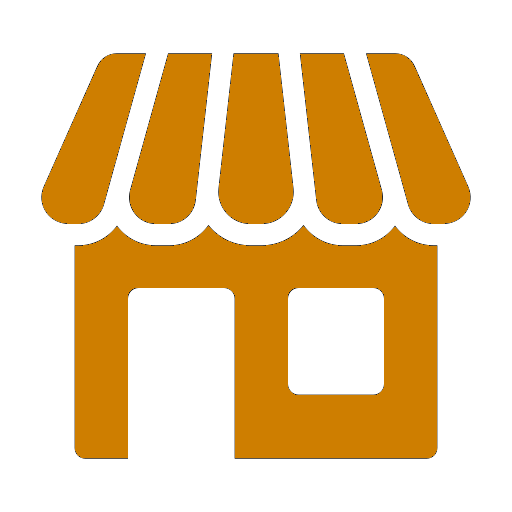
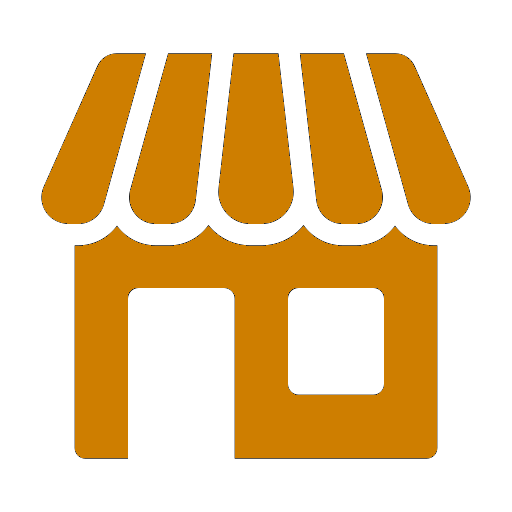
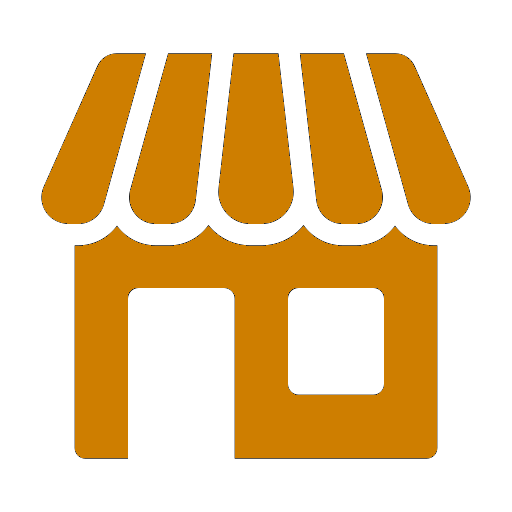
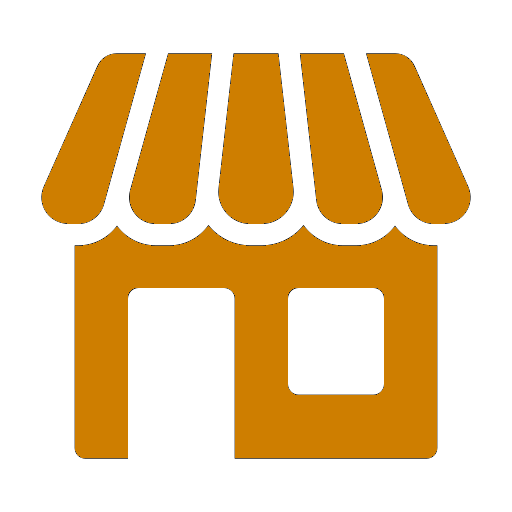
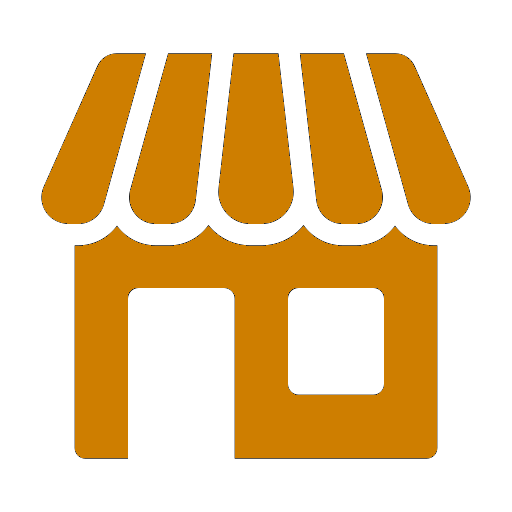
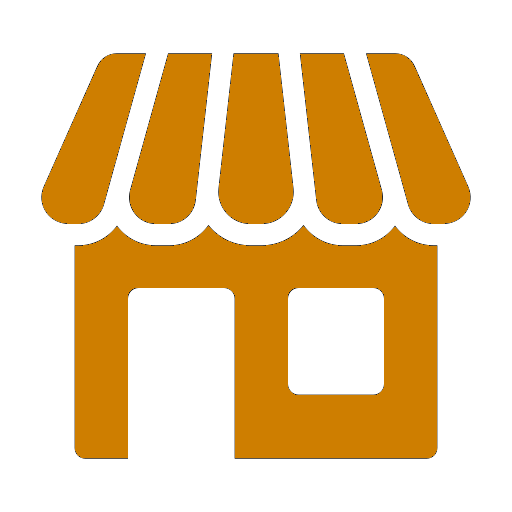
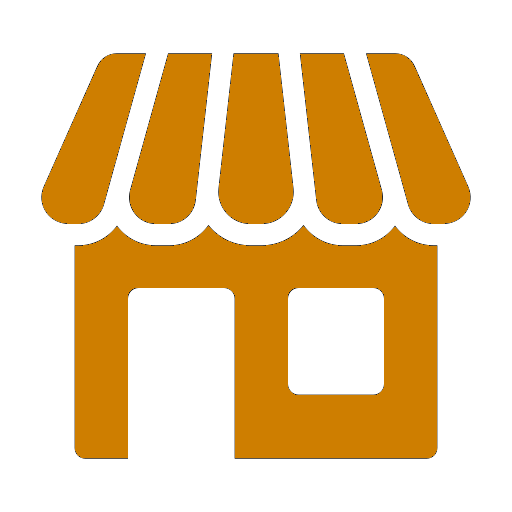
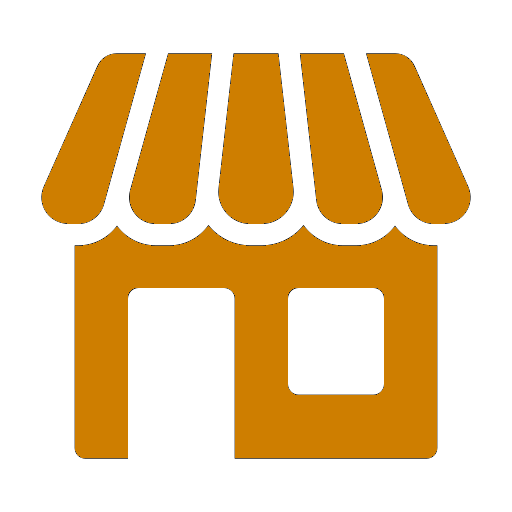
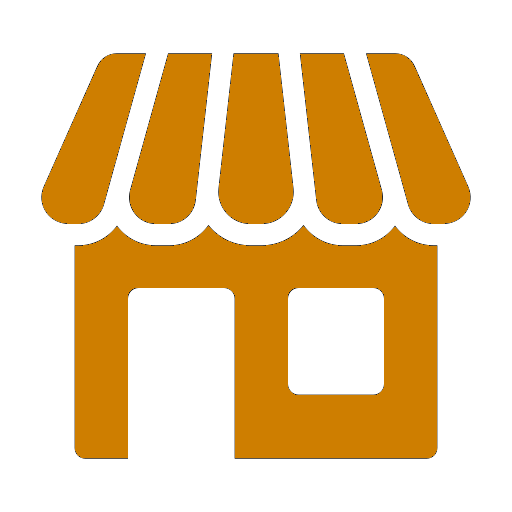
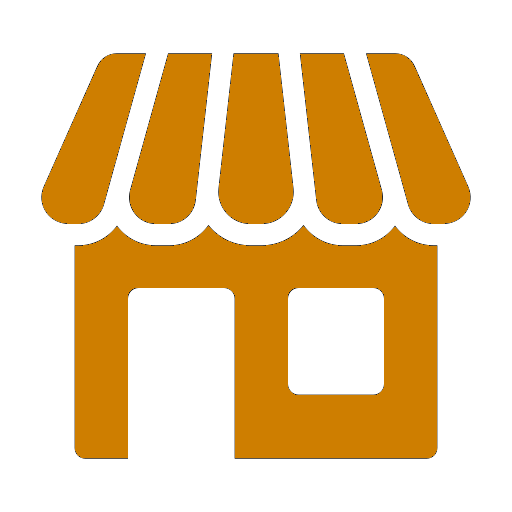
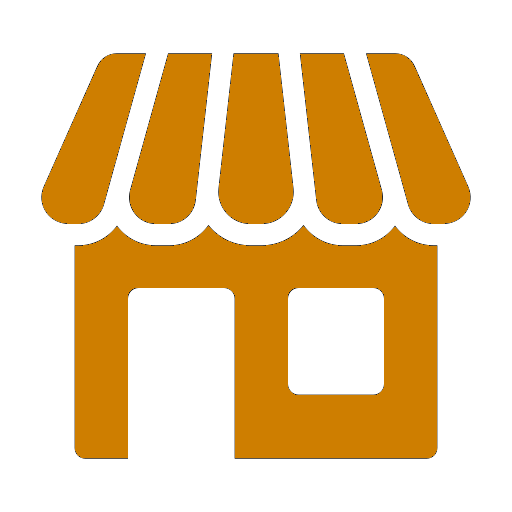
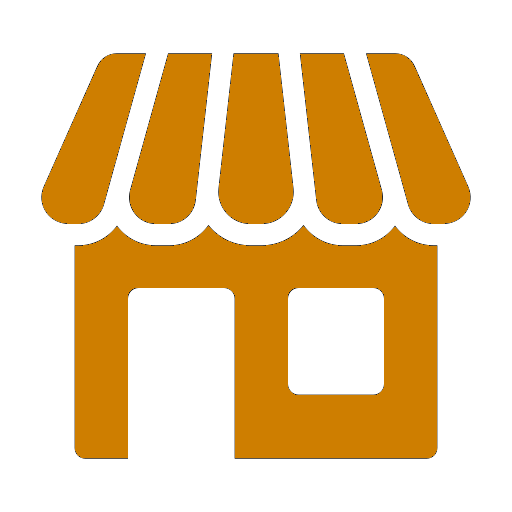
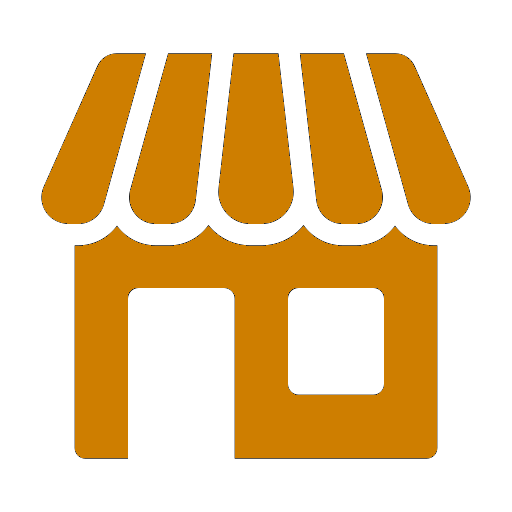
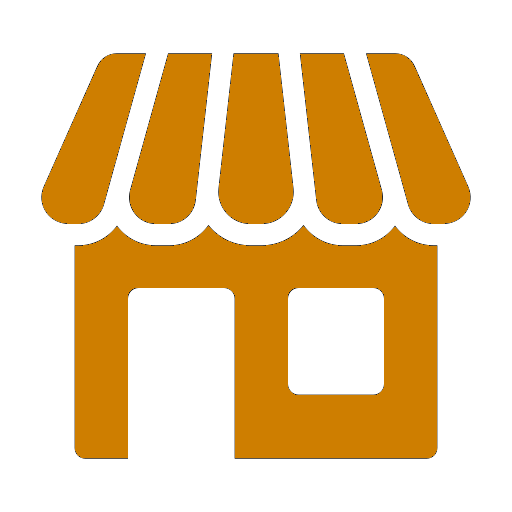
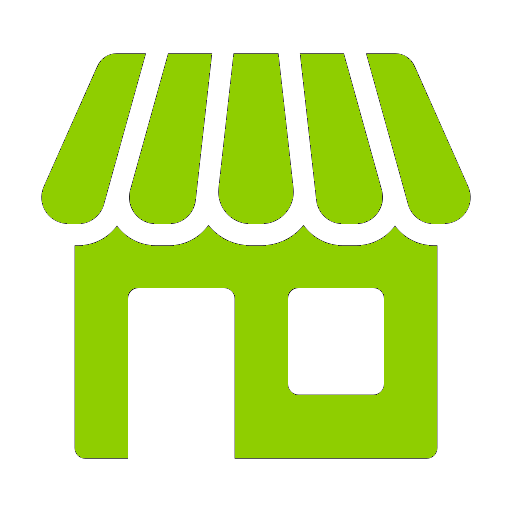
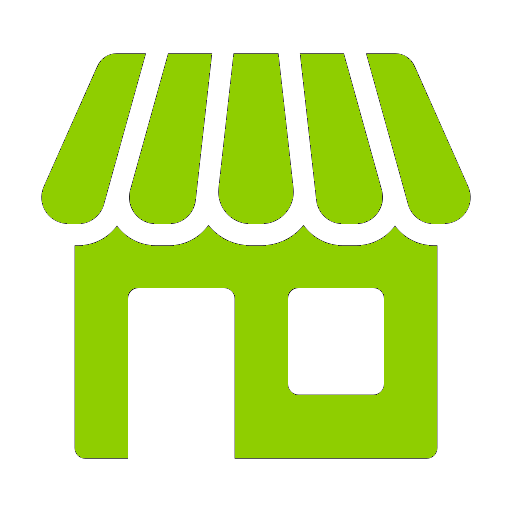
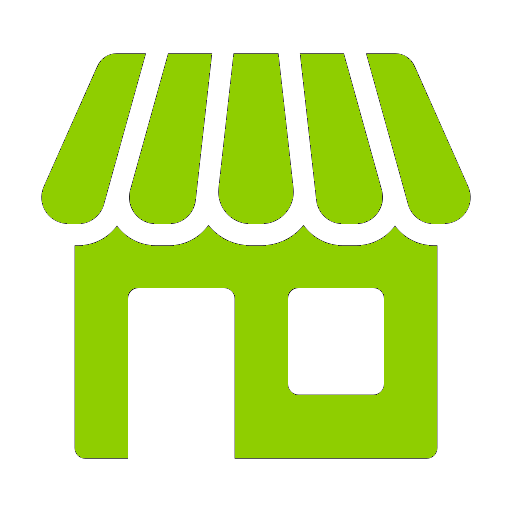
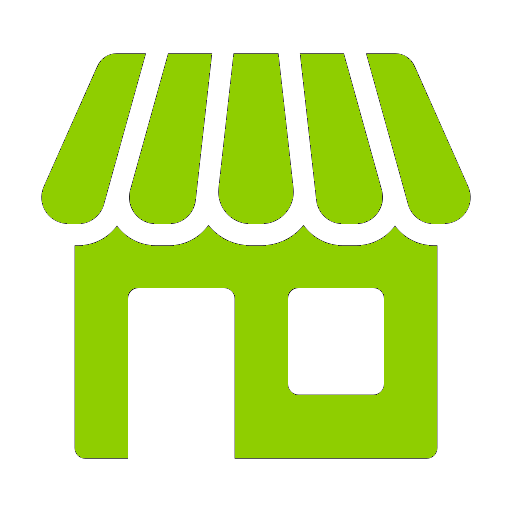
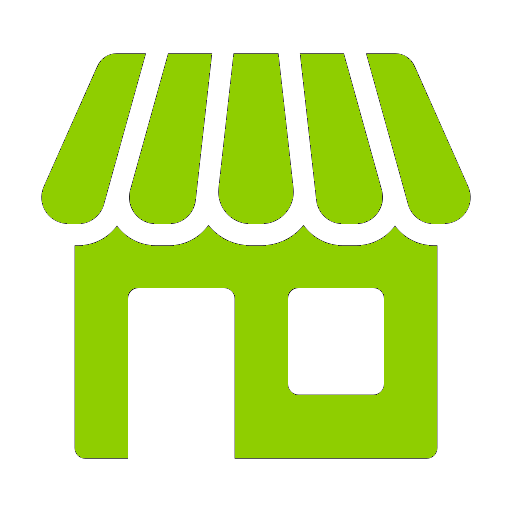
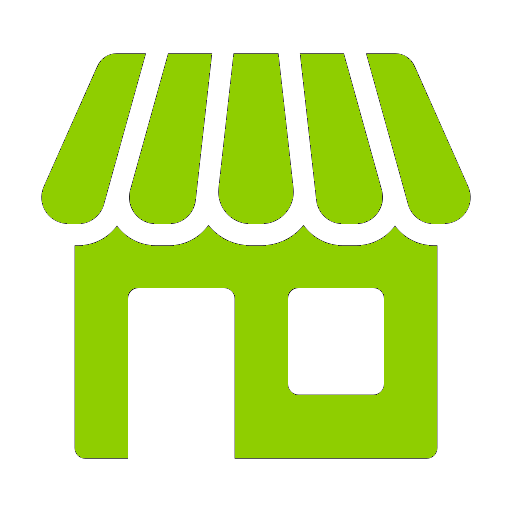
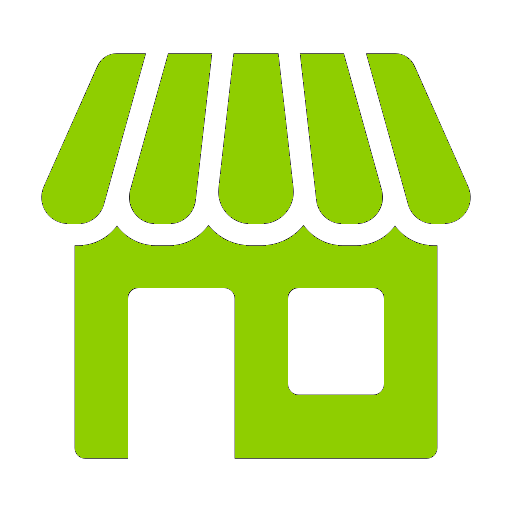
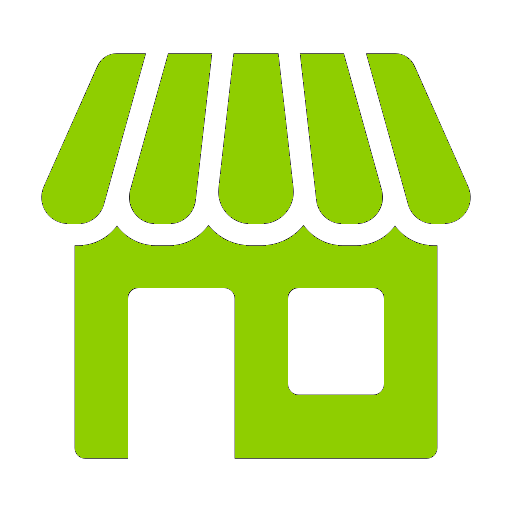
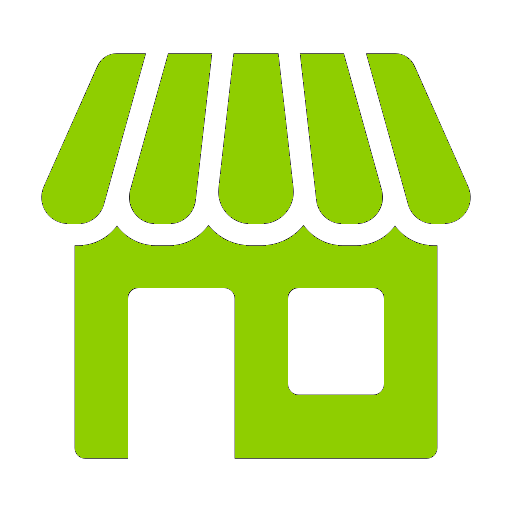
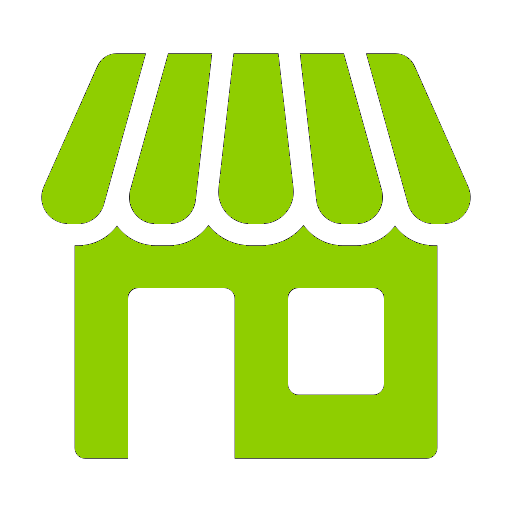
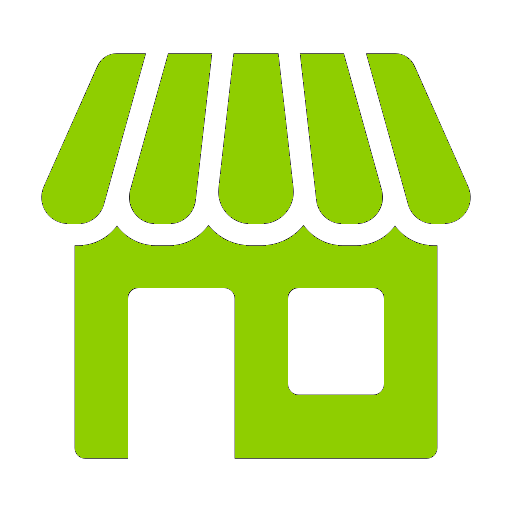
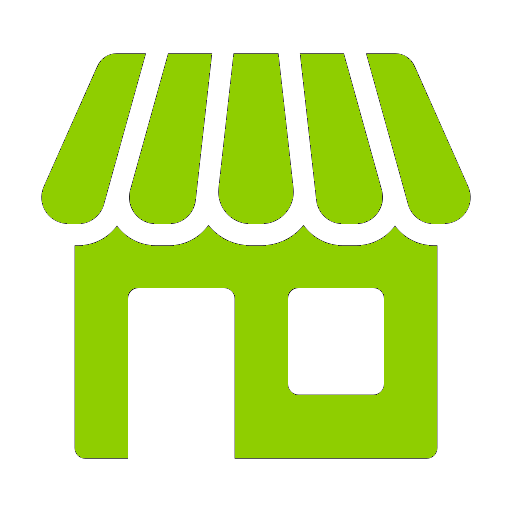
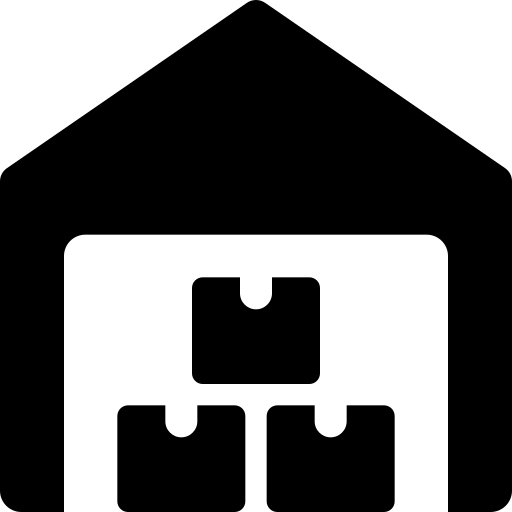

In [10]:
saturday_map = initialise_map(locations)
plot_routes(locations, selected_saturday, saturday_map)


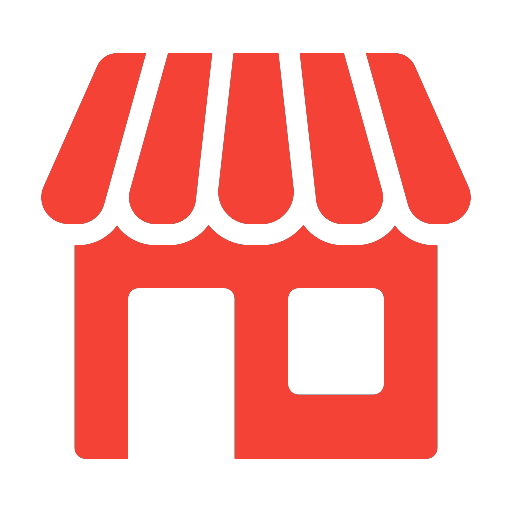
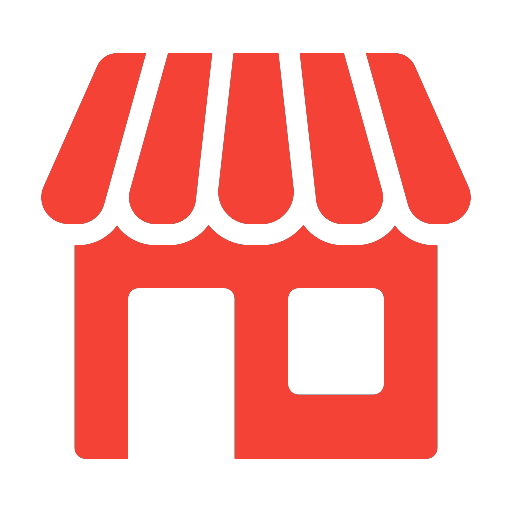
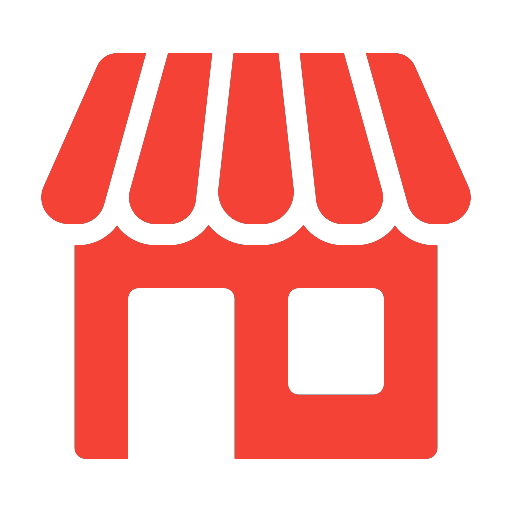
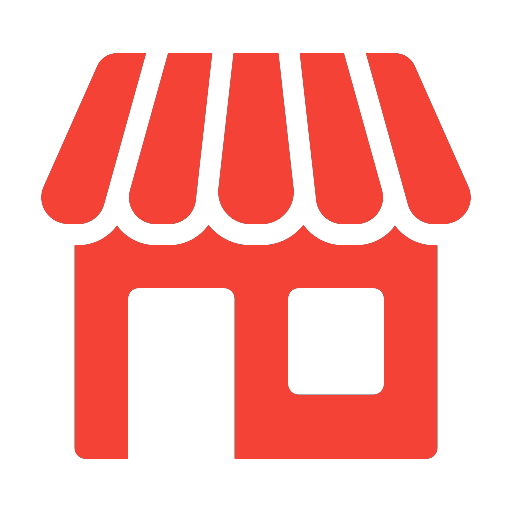
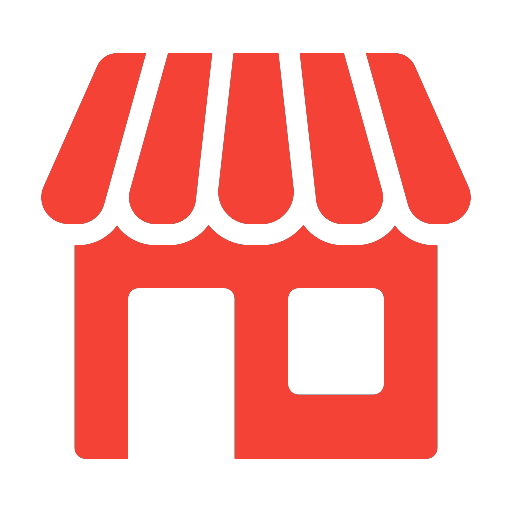
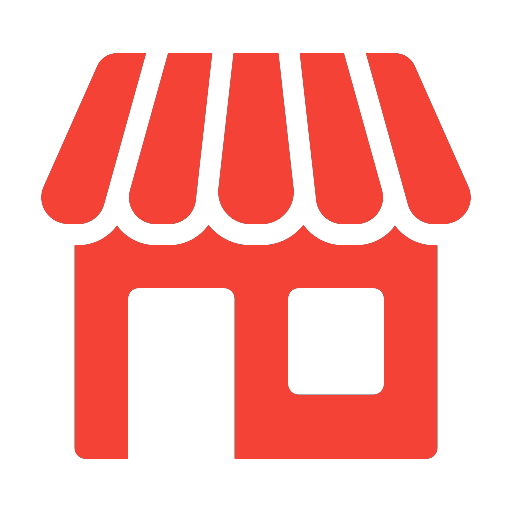
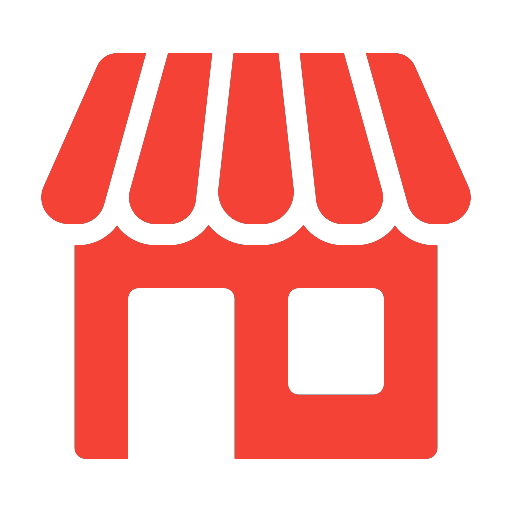
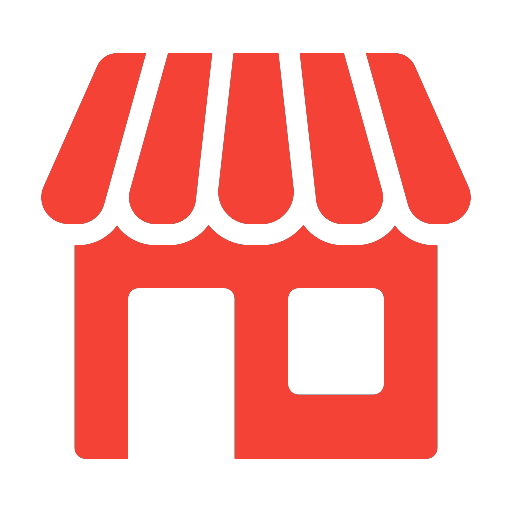
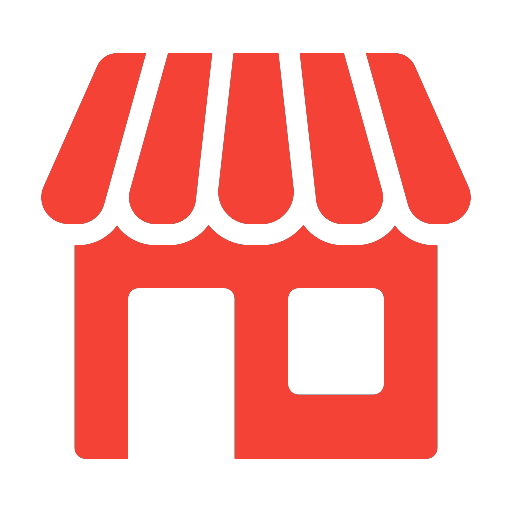
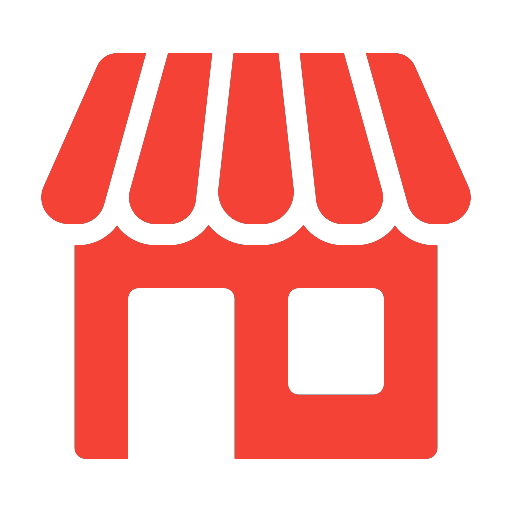
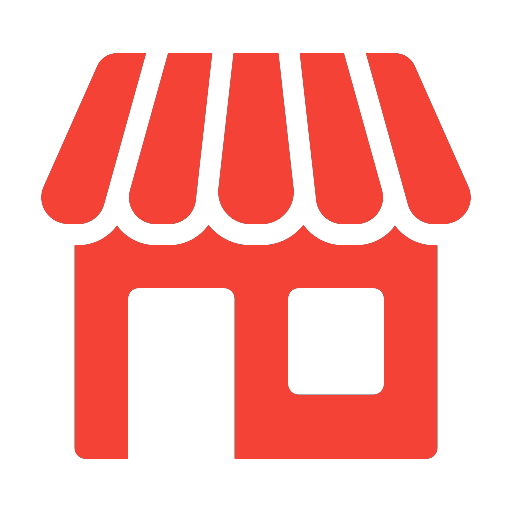
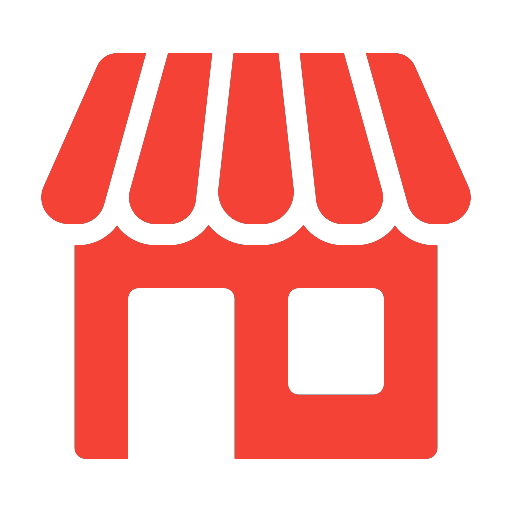
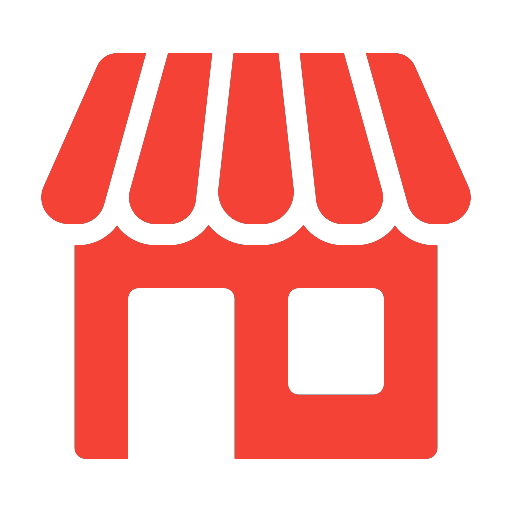
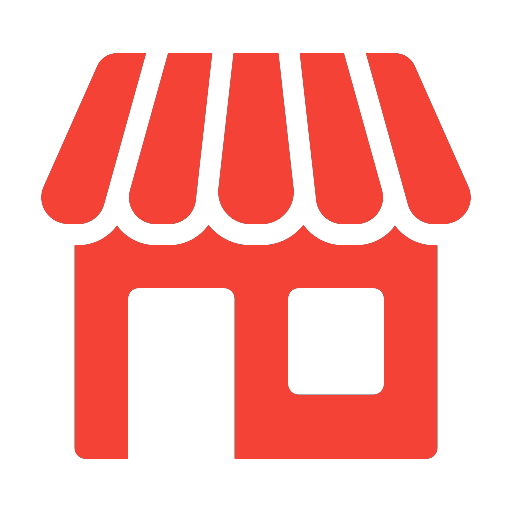
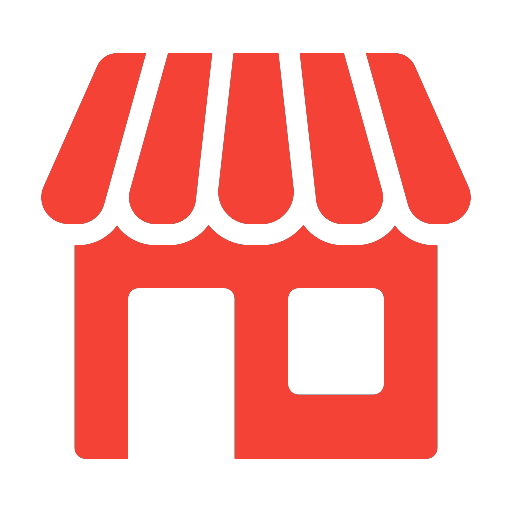
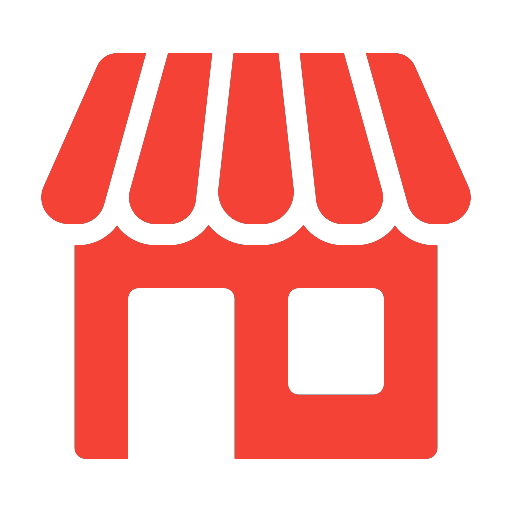
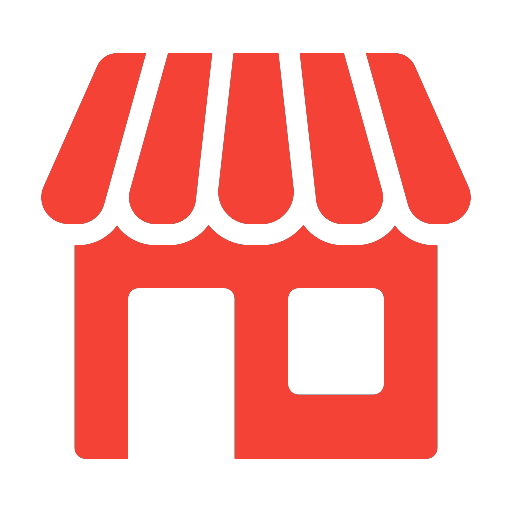
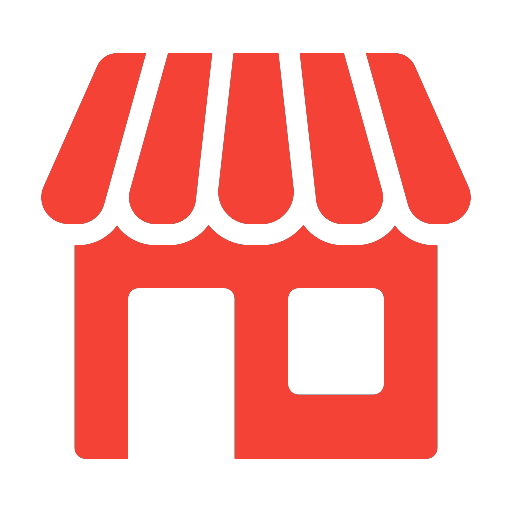
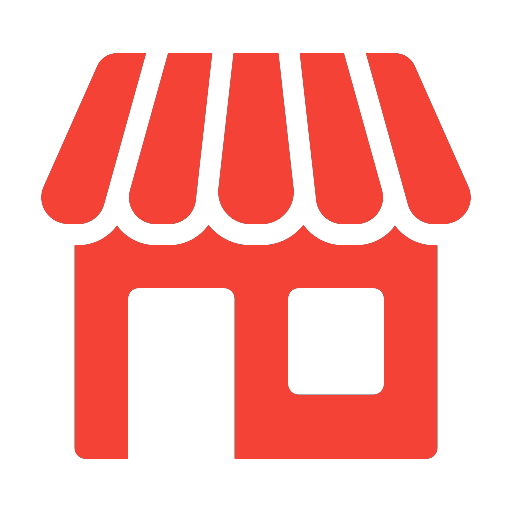
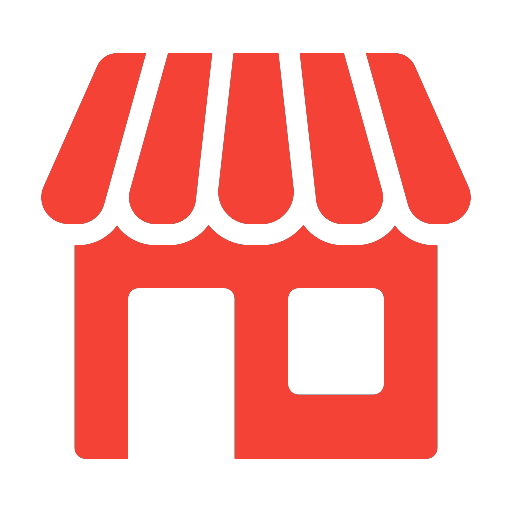
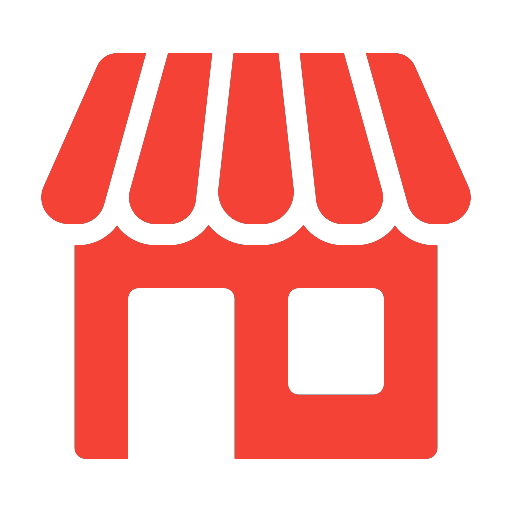
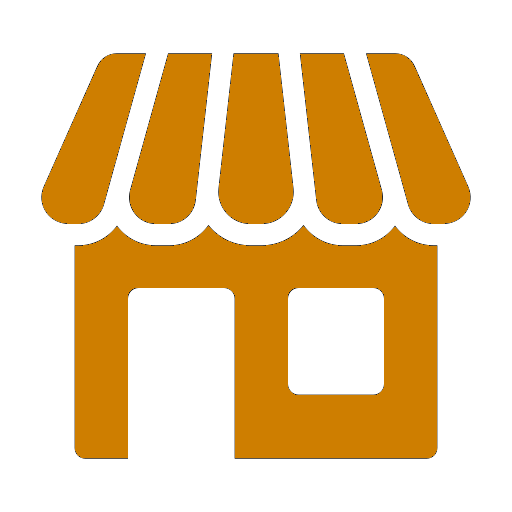
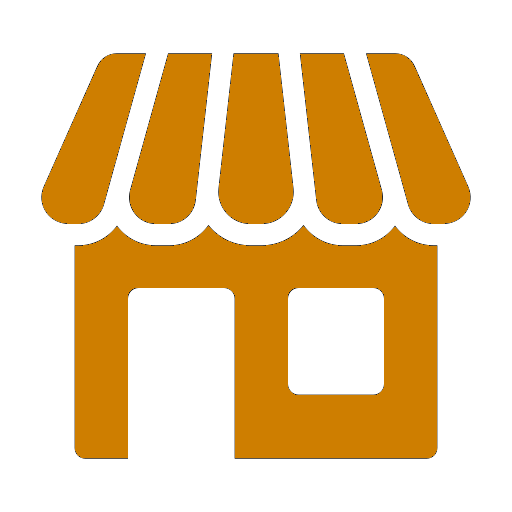
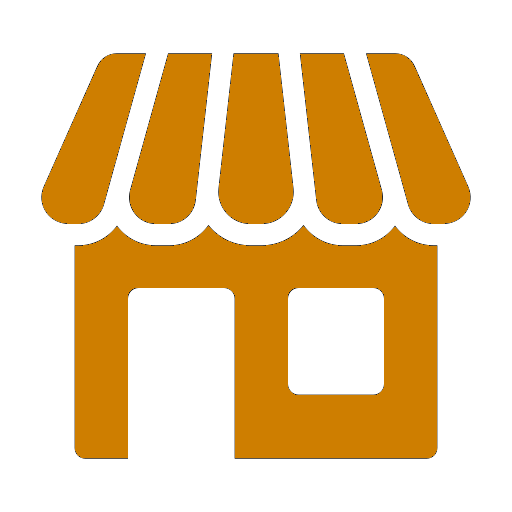
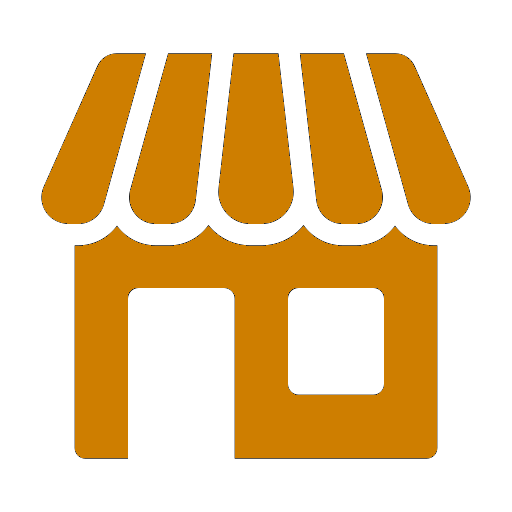
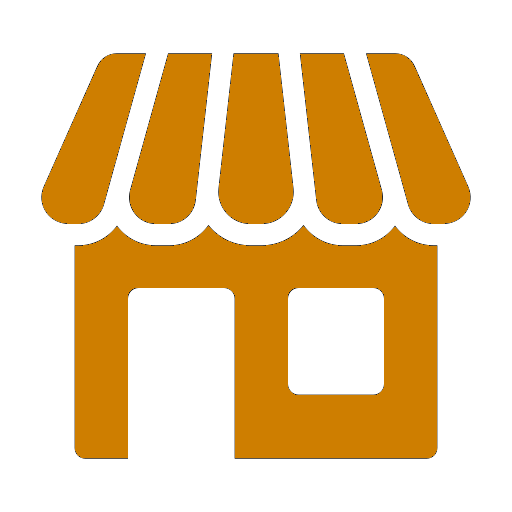
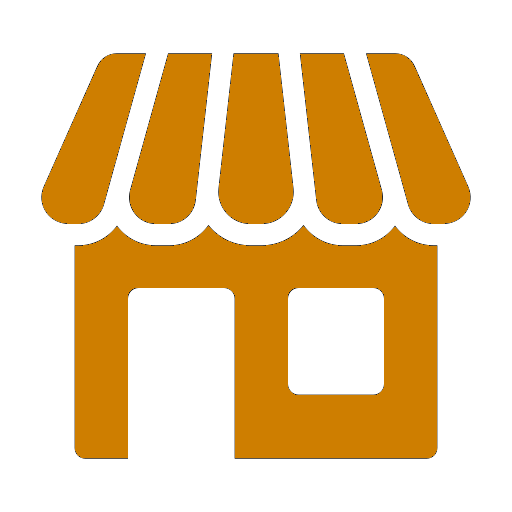
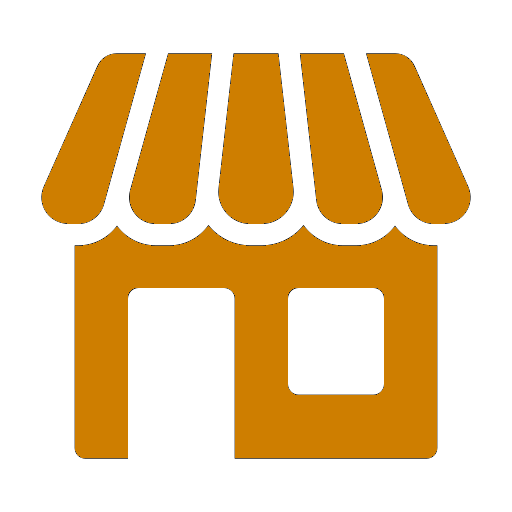
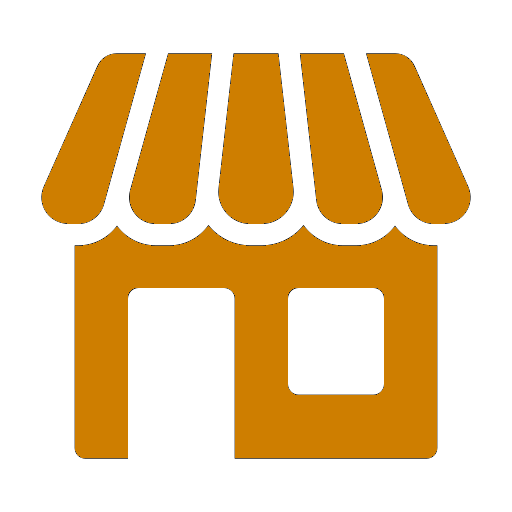
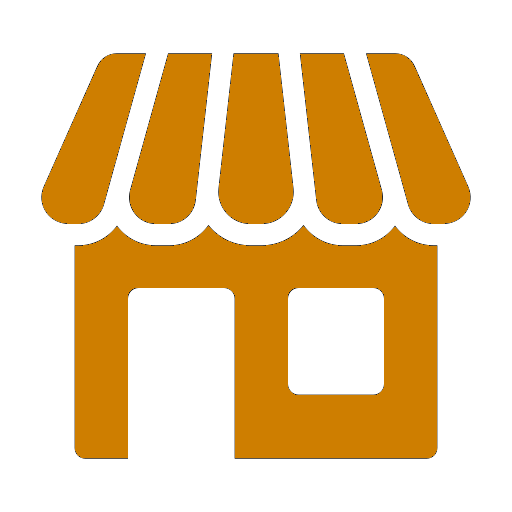
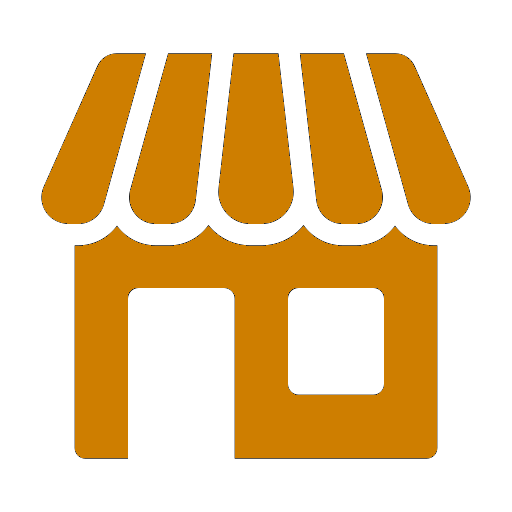
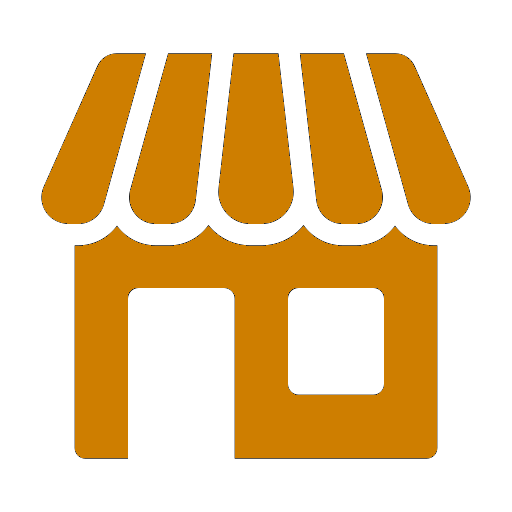
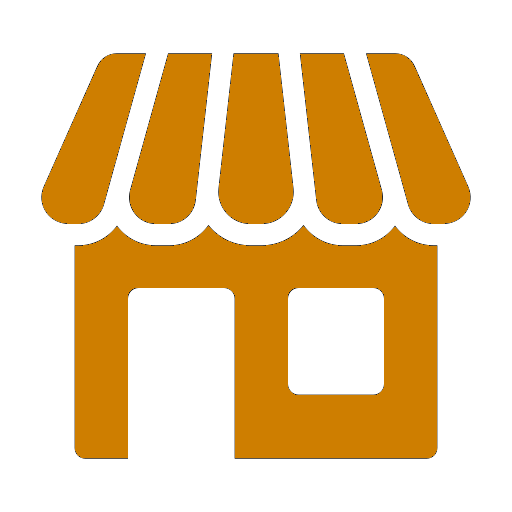
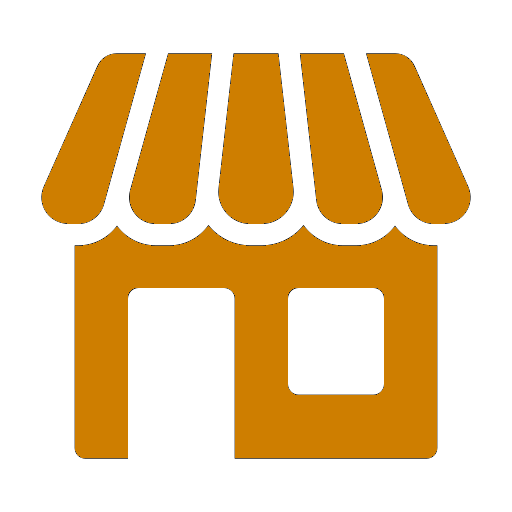
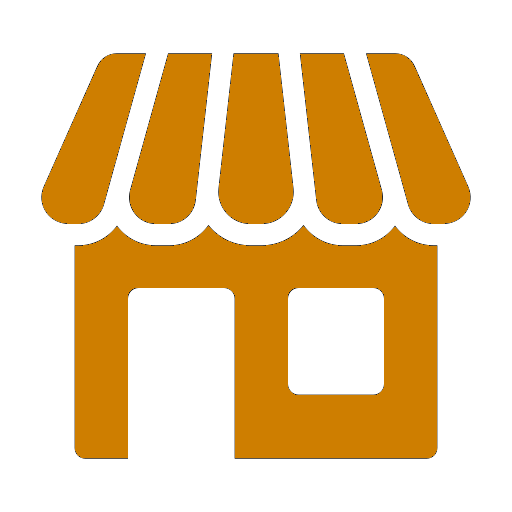
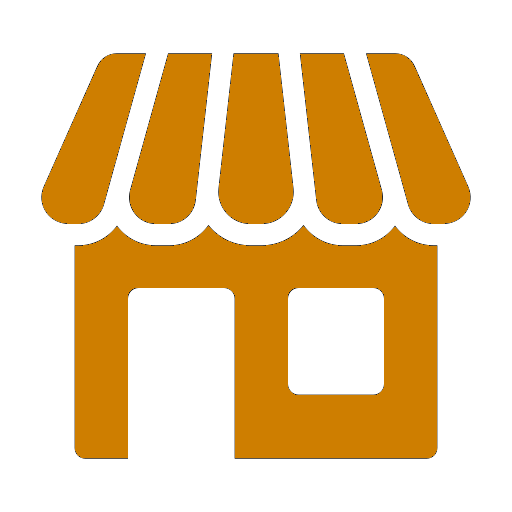
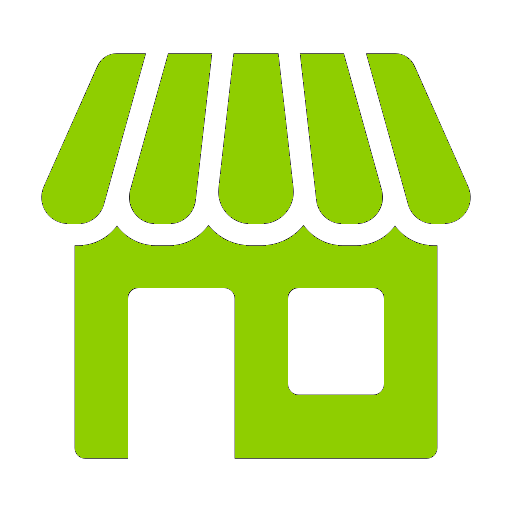
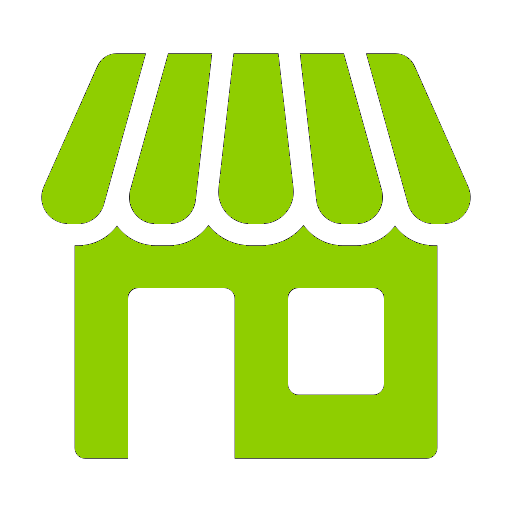
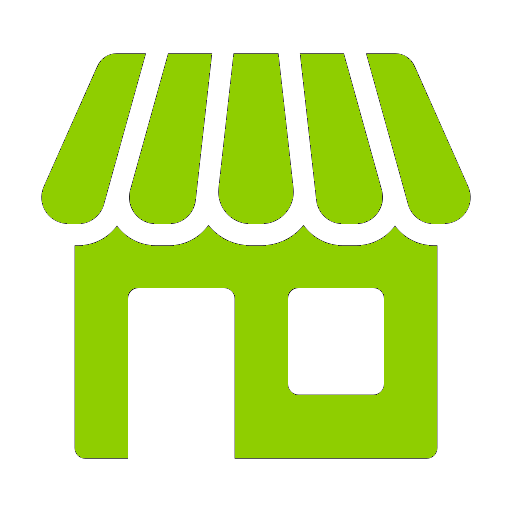
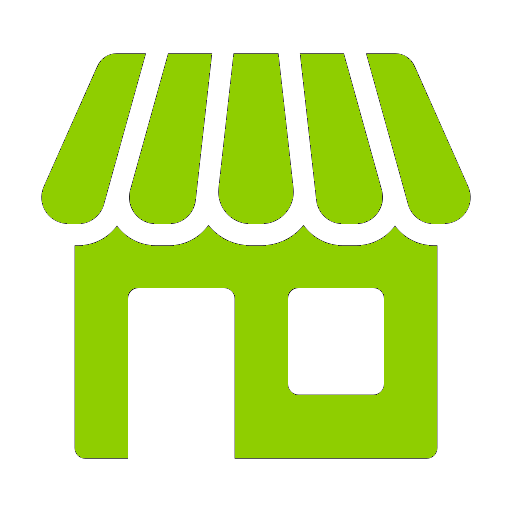
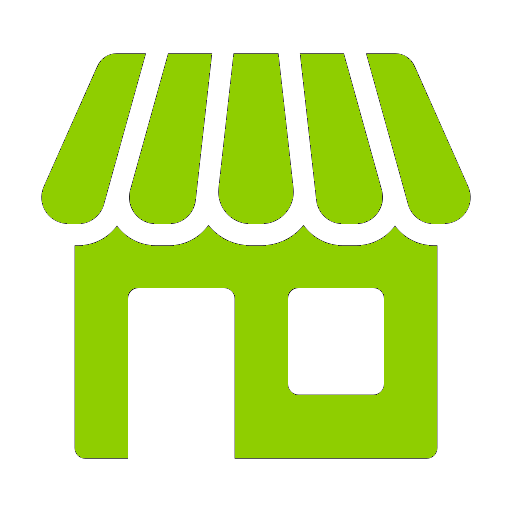
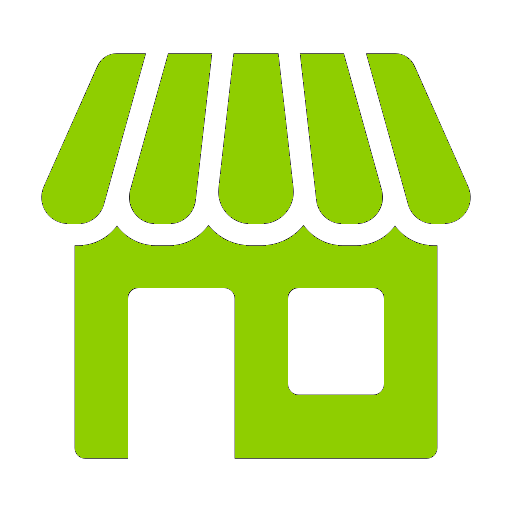
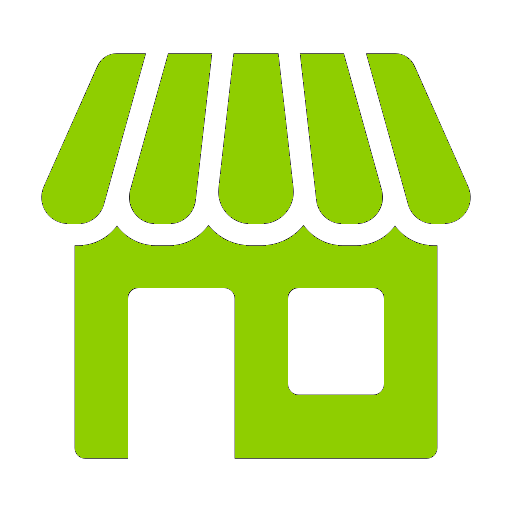
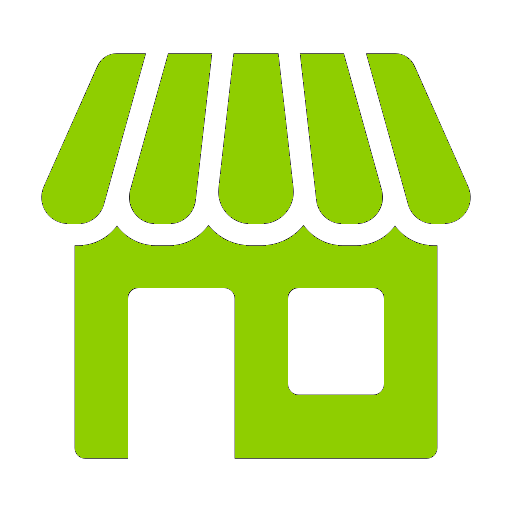
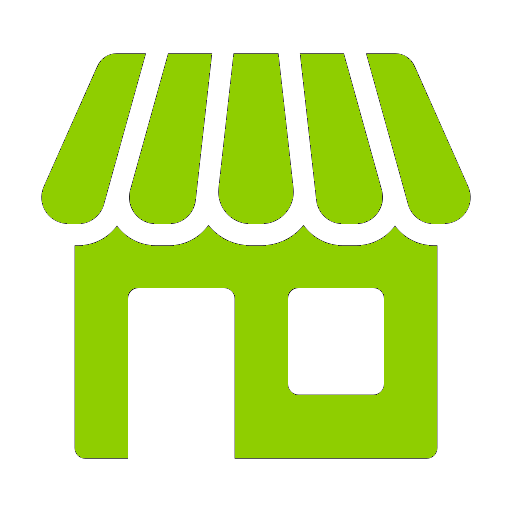
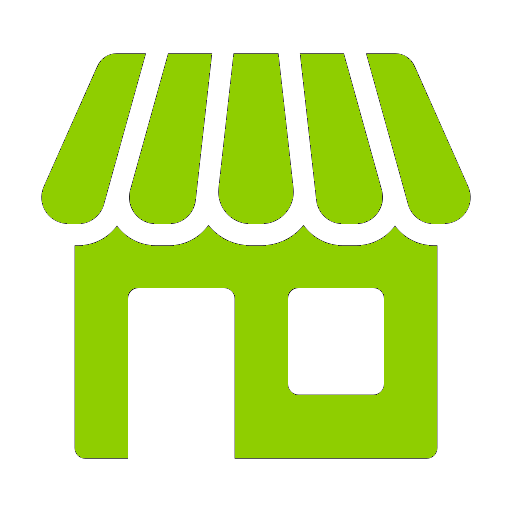
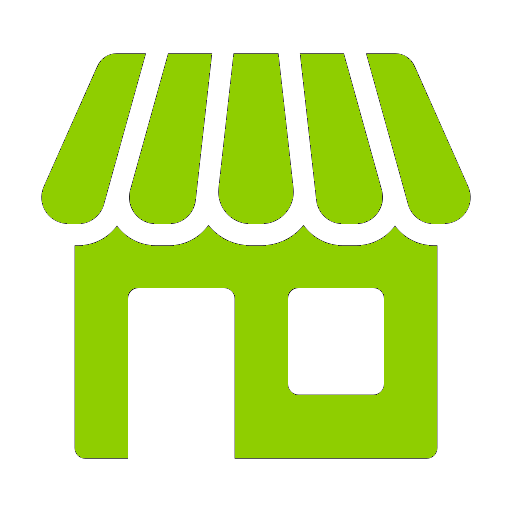
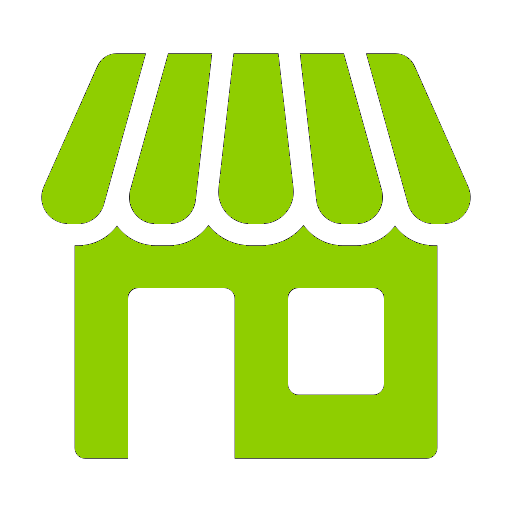
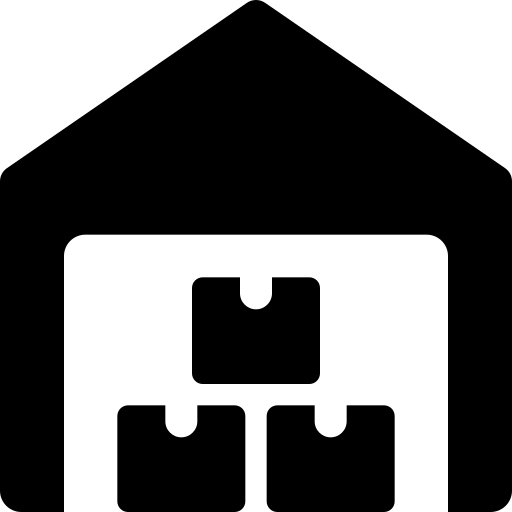

In [11]:
weekday_map = initialise_map(locations)
plot_routes(locations, selected_weekday, weekday_map)